# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Jesper Ekstrøm"
STUDENT_1_STUDENT_NUMBER = "5900468"
STUDENT_1_NETID = "jekstrom"
STUDENT_1_EMAIL = "J.Ekstrom@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Problem 1 - Vision-based angle prediction (42.5p)

**Authors:** Tomás Coleman (T.Coleman@tudelft.nl), Chuhan Zhang (C.Zhang-8@tudelft.nl)


The following cells import all the necessary packages and external functions to properly run the code. Additionally, different dataset classes are created from the information gathered in the notebook 1a. Finally, different Pytorch data loaders will be created for each network architecture which will be introduced throughout the notebook where corresponds

In [3]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
import jax
from jax import jit, lax, random
from jax import numpy as jnp
import numpy as onp
import cv2
from matplotlib import rcParams
import matplotlib.pyplot as plt
import os
from pathlib import Path
from progressbar import progressbar
from typing import Dict, Tuple
from scipy import stats

from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.utils import normalize_link_angles

import torch
from torch.utils.data import Dataset, DataLoader
import snntorch as snn
from snntorch import surrogate
import torch.nn as nn
import torch.nn.functional as F
import os
from utils import *


# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))
""
# create directory for datasets
datasets_dir = Path("datasets")
datasets_dir.mkdir(parents=True, exist_ok=True)

# create directory for plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# create directory for state dictionaries of neural network
statedicts_dir = Path("statedicts")
statedicts_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Some code to make sure GPU is being used, while also not interfering with any setup that
# might not have a GPU and could be running these tasks (like my laptop for instance).
################################### STUDENT ADDED ######################################

# Setting PYTORCH device and default tensor type to cuda.FloatTensor if GPU is available
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") # old [new again] solution, using .to(DEVICE) every time >:(

# [doing the below breaks certian things (DataLoader), and putting datasets on the GPU I run out of device memory after running cells multiple times...]
# if torch.cuda.is_available():                                                   
#     torch.set_default_tensor_type('torch.cuda.FloatTensor')

################################## Setting JAX default to GPU takes all the GPU memory, not good when using PyTorch and JAX together #####################################
# Taken from https://github.com/google/jax/issues/971
# def jaxHasGPU():
#     try:
#         _ = jax.device_put(jax.numpy.ones(1), device=jax.devices('gpu')[0])
#         return True
#     except:
#         return False

# # Setting JAX default device to GPU if it is available
# if (jaxHasGPU()):
#     print("\nJAX has a GPU available, setting default to GPU.")
#     jax_config.update("jax_platform_name", "gpu")  # set default device to 'gpu'
# else:
#     print("\nJAX doesn't have a GPU available, setting default to CPU.")
#     jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'    

########################################################################################


In [5]:
class ThetaDataset(Dataset):
    def __init__(self, dataset):
        self.x = torch.tensor(dataset["th_pix_curr"], dtype=torch.float32) / 255.0
        self.y = torch.tensor(dataset["th_curr_ss"], dtype=torch.float32)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        return x, y

    def __len__(self):
        num_samples = self.x.shape[0]

        return num_samples


class TrigDataset(Dataset):
    def __init__(self, dataset):
        self.x = torch.tensor(dataset["th_pix_curr"], dtype=torch.float32) / 255.0
        y_cos = torch.cos(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        y_sin = torch.sin(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        self.y = torch.cat((y_sin, y_cos), dim=-1)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]

        return x, y

    def __len__(self):
        num_samples = self.x.shape[0]

        return num_samples


class CNNDataset(Dataset):
    def __init__(self, dataset):
        self.x = (
            torch.tensor(
                onp.transpose(dataset["th_pix_curr"], (0, 3, 1, 2)), dtype=torch.float32
            )
            / 255.0
        )
        y_cos = torch.cos(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        y_sin = torch.sin(torch.tensor(dataset["th_curr_ss"], dtype=torch.float32))
        self.y = torch.cat((y_sin, y_cos), dim=-1)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        num_samples = self.x.shape[0]

        return num_samples


class SNNDataset(Dataset):
    def __init__(self, path, num_itr, num_data):
        self.path = path
        self.num_itr = num_itr
        self.num_data = num_data

    def __len__(self):
        return int(self.num_itr * self.num_data)

    def __getitem__(self, index):
        if index < int(self.num_data * self.num_itr):
            spike_path = "spike" + str(index) + ".pt"
            label_path = "target" + str(index) + ".pt"
            spike_out = torch.load(os.path.join(self.path, spike_path))
            label_out = torch.load(os.path.join(self.path, label_path))
            return spike_out, label_out
        else:
            raise IndexError

In [6]:
def load_training_dataset_dataloader(
    _filepath, _rng: random.KeyArray, _val_ratio=0.3, batch_size=64, model_type="theta"
):
    assert 0.0 <= _val_ratio <= 1.0, "Validation ratio needs to be in interval [0, 1]."

    _dataset = jnp.load(_filepath)
    num_samples = _dataset["th_curr_ss"].shape[0]

    indices = jnp.arange(num_samples)
    shuffled_indices = random.permutation(_rng, indices)
    num_train_samples = int((1 - _val_ratio) * num_samples)
    split_config = jnp.array(
        [
            num_train_samples,
        ]
    )
    train_indices, val_indices = jnp.split(shuffled_indices, split_config)

    _train_ds, _val_ds = {}, {}
    for key, val in _dataset.items():
        _train_ds[key] = val[train_indices]
        _val_ds[key] = val[val_indices]

    if model_type == "theta":
        train_data = ThetaDataset(_train_ds)
        val_data = ThetaDataset(_val_ds)
    elif model_type == "trig":
        train_data = TrigDataset(_dataset)
        val_data = TrigDataset(_val_ds)
    elif model_type == "cnn":
        train_data = CNNDataset(_dataset)
        val_data = CNNDataset(_val_ds)

    _train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=batch_size, shuffle=True#, pin_memory=True # <-- better Host->GPU transfer #generator=torch.Generator(device=DEVICE) # <---- added to support GPUU
    )
    _val_dataloader = torch.utils.data.DataLoader(
        val_data, batch_size=batch_size, shuffle=True#, pin_memory=True # <-- better Host->GPU transfer #generator=torch.Generator(device=DEVICE) # <---- added to support GPU
    )

    return _train_dataloader, _val_dataloader


def load_test_dataset_dataloader(
    _filepath, _rng: random.KeyArray, batch_size=64, model_type="theta"
):
    _dataset = jnp.load(_filepath)
    num_samples = _dataset["th_curr_ss"].shape[0]

    if model_type == "theta":
        print("Theta Dataset")
        _data = ThetaDataset(_dataset)

    elif model_type == "trig":
        print("Trig Dataset")
        _data = TrigDataset(_dataset)
    elif model_type == "cnn":
        print("CNN dataset")
        _data = CNNDataset(_dataset)

    _dataloader = torch.utils.data.DataLoader(
        _data, batch_size=batch_size, shuffle=False#, pin_memory = True # <-- better Host->GPU transfer #generator=torch.Generator(device=DEVICE) # <---- added to support GPUU
    )
    return _dataloader, _dataset

One last function, evaluate_model, is also defined to evaluate the outcomes of the different models in their respective datasets and display a heatmap of the prediction errors. You do not have to worry about its workings nor interface since you are not required to use it yourself

In [7]:
def evaluate_model(
    _model, test_dataset, model="theta", file="nothing.pdf", num_bins: int = 10
):
    filepath = str(outputs_dir / file)
    th = test_dataset["th_curr_ss"]

    # The pixel values need to be divided by 255.0 to match the input of the dataset classes
    if model == "cnn":
        x = onp.transpose(
            onp.array(test_dataset["th_pix_curr"] / 255.0, dtype=onp.float32),
            (0, 3, 1, 2),
        )
        x = torch.tensor(x)
        x_len = x.size()[0]
        batch_size = 100
        batch_num = int(int(x_len) / int(batch_size))
        y_hat = torch.zeros((0, 4))
        for i in range(batch_num):
            x_batch = x[int(i * batch_size) : int((i + 1) * batch_size)].to(DEVICE) # .to(DEVICE) added for GPU support
            y_batch = _model(x_batch).cpu().detach()                                # .cpu() added for GPU support
            y_hat = torch.cat((y_hat, y_batch), dim=0)
        y_hat = y_hat.numpy()
    else:
        y_hat = (
            _model(
                torch.tensor(
                    onp.array(test_dataset["th_pix_curr"] / 255.0, dtype=onp.float32)
                ).to(DEVICE)                                                        # .to(DEVICE) added for GPU support
            ).cpu()                                                                 # .cpu() added for GPU support
            .detach()
            .numpy()
        )  # need to convert back to np array

    if model == "theta":
        y = th
    else:
        y_cos = onp.cos(th)
        y_sin = onp.sin(th)

        y = onp.concatenate((y_sin, y_cos), axis=-1)

        y = trig_to_theta_numpy(y)
        y_hat = trig_to_theta_numpy(y_hat)

    error = y_hat - y
    error = onp.abs(error)

    extent = onp.array(
        [
            [-onp.pi, onp.pi],
            [-onp.pi, onp.pi],
        ]
    )
    heatmap, xedges, yedges = onp.histogram2d(
        x=th[:, 0], y=th[:, 1], bins=num_bins, range=extent
    )

    avg_bins = onp.zeros((num_bins, num_bins))
    for i in range(avg_bins.shape[0]):
        if i == 0:
            # also include the left edge for the first bin
            xcond = (xedges[i] <= th[:, 0]) & (th[:, 0] <= xedges[i + 1])
        else:
            xcond = (xedges[i] < th[:, 0]) & (th[:, 0] <= xedges[i + 1])

        for j in range(avg_bins.shape[1]):
            if j == 0:
                # also include the left edge for the first bin
                ycond = (yedges[j] <= th[:, 1]) & (th[:, 1] <= yedges[j + 1])
            else:
                ycond = (yedges[j] < th[:, 1]) & (th[:, 1] <= yedges[j + 1])

            # combine condition for th1 and th2
            bin_cond = xcond & ycond

            # save the average error for each bin
            avg_bins[i, j] = onp.mean(error[bin_cond, :])

    print("Mean prediction error across bins:", onp.mean(avg_bins))

    plt.clf()

    plt.imshow(avg_bins, extent=extent.flatten())
    plt.title("Heatmap of prediction error")
    plt.xlabel("link 1 angles (rad)")
    plt.ylabel("link 2 angles (rad)")

    plt.colorbar()
    plt.savefig(filepath)
    plt.show()


def trig_to_theta(trig_data):
    raise RuntimeError("Use trigToTheta() instead")
    trig_len = trig_data.shape[0]
    theta = torch.zeros(trig_len, 2)
    for i in onp.arange(trig_len):
        theta[i, 0] = torch.atan2(trig_data[i, 0], trig_data[i, 2])
        theta[i, 1] = torch.atan2(trig_data[i, 1], trig_data[i, 3])
    return theta

def trig_to_theta_numpy(trigData):
#     trig_len = trigData.shape[0]
#     theta = onp.zeros((trig_len, 2))
#     for i in range(trig_len):
#         theta[i, 0] = onp.arctan2(trigData[i, 0], trigData[i, 2])
#         theta[i, 1] = onp.arctan2(trigData[i, 1], trigData[i, 3])
    return onp.concatenate(\
        [onp.expand_dims(onp.arctan2(trigData[:,0], trigData[:,2]), axis=-1), 
         onp.expand_dims(onp.arctan2(trigData[:,1], trigData[:,3]), axis=-1)],
        axis=1)

In [8]:
# set seed for jax
rng = jax.random.PRNGKey(seed=42)
rng, init_rng = jax.random.split(rng)

## Task 1.1: Learn to predict angles (7.5p)

We are going to create models that try to predict the link angles $\hat{\theta}$ given an image of the robot, so $\theta \approx \hat{\theta} =M(x)$.

### 1.1 - Prepare data 
Run the functions below to load the data generated in `task_1a_generate_data.ipynb`, split the training into the 70/30 train/validation split, set the batch size to and put them in a dataloader. The data is first put in the class `ThetaDataset`. This class converts the `uint8` pixel values from a range of 0-255 to float values in the range `0-1`. The class also provides methods for the dataloader to retreive the pixel obervations `.x` and test labels `y`. The dataloader is set to Shuffle the data randomly before enumerating during the training loop.

In [9]:
if not AUTOGRADING:
    train_loader_theta, val_loader_theta = load_training_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_train.npz"),
        _rng=init_rng,
        model_type="theta",
    )
    test_loader_theta, test_dataset_theta = load_test_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_test.npz"),
        _rng=init_rng,
        model_type="theta",
    )

Theta Dataset


### 1.1 - Create the model (1.5p)
Here, create a PyTorch model class called NeuralNetworkTheta()
- Start by flattening the input with `torch.nn.Flatten()`.
- Then, add a fully connected hidden layer `torch.nn.Linear(...)` of 128 units and ReLU activation.
- Finally, add a final fully connected linear layer `torch.nn.Linear(...)`without activation. The number of units must match the dimension of our target data, which is 2, as we try to predict the angles $\theta_1$ and $\theta_2$.


In [10]:
"""
NN Model with Theta as the output
"""

""" TASK 1.1: CREATE MODEL HERE """

INPUT_SHAPE_THETA = int(onp.prod(next(iter(train_loader_theta))[0].size()[1::]))
print("\nSamples have flattened shape:", INPUT_SHAPE_THETA)

class NeuralNetworkTheta(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.layer1 = torch.nn.Flatten()
        self.layer2 = torch.nn.Linear(INPUT_SHAPE_THETA, 128)
        self.layer3 = torch.nn.Linear(128, 2)
    
    def forward(self, x):
        return self.layer3(torch.nn.functional.relu(self.layer2(self.layer1(x))))
    
"""TASK1.1: END"""
model_theta = torch.jit.script(NeuralNetworkTheta().to(DEVICE))

total_params_theta = sum(p.numel() for p in model_theta.parameters())
print("total number of model parameters:", total_params_theta)


Samples have flattened shape: 3072
total number of model parameters: 393602


### 1.1 - Train the model (2p) 

Now that the model is defined, we can train it using the training dataset. We have a train-validation split of 0.3 and a batch size of 64 that is shuffled every epoch. Train the model for 100 epochs with the training data `train_loader_theta`. Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 100 epochs. Do this 10 times and record the prediction error of the final model of each of the 10 runs on the test dataset `test_loader_theta` using the function `evaluate_model_test_data_theta`. For each training loop, it would be useful to test the model performance on the valedation set to see if it is overfitting on the training data or whether it can generalize well. **hint:** 
- reduce the number of epochs and lower the number of runs to `1` while getting your model working and setting the optimal learning rate. 
- The try variying the the learning rate in the range of `1e-1` to `1e-5`.
 

In [11]:
#################################################### TASK ONE COMMON FUNCTIONS ###########################################################
##########################################################################################################################################
from collections.abc import Callable

# Plotting helper function
def lowEffortPlot(epochErrorHistory, testError, num_epochs):
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.set_title(f"Run {run+1} L1-Norm Training and Validation Errors")
    ax.plot(epochErrorHistory["Training Error"], label="Training Error")
    ax.plot(epochErrorHistory["Validation Error"], label="Validation Error")
    ax.axhline(testError, ls="--", label="Test Error")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("L1-Norm Error")
    ax.set_xticks([x for x in onp.arange(num_epochs) if x % 5 == 0])
    ax.legend()
    plt.show()

# Printing helper functioon
def printLossAndError(typeOfData: str, runningLoss: float, runningError: float, stepsPerEpoch: int) -> None:
    print(f"{typeOfData} loss: {runningLoss / stepsPerEpoch:.3f}, {typeOfData} prediction error: {runningError / stepsPerEpoch:.3f}")  
    
# Validation/test evaluation function
def evaluateRunningModel(model :torch.nn.Module, 
                         dataLoader :torch.utils.data.dataloader.DataLoader, 
                         typeOfData :str,
                         decoderFunction: Callable[[torch.Tensor], torch.Tensor] = lambda X: X,
                         lossFunction: torch.nn.modules.loss._Loss = torch.nn.MSELoss(),
                         errorFunction: torch.nn.modules.loss._Loss = torch.nn.L1Loss(),
                         printOut: bool = True,
                        ) -> float:
    
    runningLoss = 0.0
    runningError = 0.0
    stepsPerEpoch = len(dataLoader)
    with torch.no_grad():
        for inputs, labels in dataLoader:
            inputs = inputs.to(DEVICE)
            labels = decoderFunction(labels.to(DEVICE))
            predictions = decoderFunction(model(inputs))
            loss = lossFunction(predictions, labels)
            error = errorFunction(predictions, labels)
            runningLoss += loss.item()
            runningError += error.item()
                  
    if printOut: printLossAndError(typeOfData, runningLoss, runningError, stepsPerEpoch)
    return runningError / stepsPerEpoch

# Main somewhat generic model training function
def runTraining(model :torch.nn.Module,
                optimizer :torch.optim.Optimizer,
                numEpochs :int,
                trainingDataLoader :torch.utils.data.dataloader.DataLoader, 
                validationDataLoader :torch.utils.data.dataloader.DataLoader,
                modelEvaluationFunction :Callable[[torch.nn.Module, torch.utils.data.dataloader.DataLoader, str, ...], float],
                lossFunction :torch.nn.modules.loss._Loss = torch.nn.MSELoss(),
                errorFunction :torch.nn.modules.loss._Loss = torch.nn.L1Loss(),
                decoderFunction: Callable[[torch.Tensor], torch.Tensor] = lambda X: X
               ) -> dict:
    torch.cuda.empty_cache() # just doing this here so I can't forget in any of the training loops, yes its poor function cohesion
    stepsPerEpochTrain = len(trainingDataLoader)
    stepsPerEpochValidate = len(validationDataLoader)
    epochErrorHistory = {"Training Error" : [None]*numEpochs, "Validation Error" : [None]*numEpochs}
    # Iterate over epochs to train
    for epoch in onp.arange(numEpochs):
        print(f"\nEpoch {epoch + 1}:")
        runningLoss = 0.0
        runningError = 0.0
        # Iterate over samples (batches) in training dataset
        for inputs, labels in trainingDataLoader:
            optimizer.zero_grad()
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            # Forward pass and loss computation
            predictions = model(inputs)
            rawLoss = lossFunction(predictions, labels)
            # Backward pass; update weights and biases
            rawLoss.backward()
            optimizer.step()
            # Update the decoded training loss and error of predictions
            runningLoss += lossFunction(decoderFunction(predictions), decoderFunction(labels)).item()
            runningError += errorFunction(decoderFunction(predictions), decoderFunction(labels)).item()
            # Avoid exploding memory
            del predictions, rawLoss, inputs, labels
            torch.cuda.empty_cache()
        # Print and store training and validation error and loss
        printLossAndError("Training", runningLoss, runningError, stepsPerEpochTrain)
        epochErrorHistory["Training Error"][epoch] = runningError / stepsPerEpochTrain
        epochErrorHistory["Validation Error"][epoch] = modelEvaluationFunction(model, validationDataLoader, "Validation", lossFunction = lossFunction, errorFunction = errorFunction, decoderFunction = decoderFunction)
    return epochErrorHistory

# Faster conversion from trigonometric outputs to theta
@torch.jit.script
def trigToTheta(trigData: torch.Tensor) -> torch.Tensor:
    return torch.cat([torch.unsqueeze(torch.atan2(trigData[:,0], trigData[:,2]), -1), torch.unsqueeze(torch.atan2(trigData[:,1], trigData[:,3]), -1)], dim=1)   

##########################################################################################################################################
##########################################################################################################################################


Epoch 1:
Training loss: 3.238, Training prediction error: 1.552
Validation loss: 3.244, Validation prediction error: 1.561

Epoch 2:
Training loss: 3.180, Training prediction error: 1.537
Validation loss: 3.192, Validation prediction error: 1.547

Epoch 3:
Training loss: 3.129, Training prediction error: 1.523
Validation loss: 3.138, Validation prediction error: 1.532

Epoch 4:
Training loss: 3.074, Training prediction error: 1.508
Validation loss: 3.082, Validation prediction error: 1.516

Epoch 5:
Training loss: 3.015, Training prediction error: 1.491
Validation loss: 3.021, Validation prediction error: 1.499

Epoch 6:
Training loss: 2.949, Training prediction error: 1.472
Validation loss: 2.948, Validation prediction error: 1.477

Epoch 7:
Training loss: 2.874, Training prediction error: 1.449
Validation loss: 2.874, Validation prediction error: 1.454

Epoch 8:
Training loss: 2.795, Training prediction error: 1.424
Validation loss: 2.786, Validation prediction error: 1.427

Epoch 9

Training loss: 1.546, Training prediction error: 0.813
Validation loss: 1.575, Validation prediction error: 0.823

Epoch 68:
Training loss: 1.542, Training prediction error: 0.811
Validation loss: 1.559, Validation prediction error: 0.817

Epoch 69:
Training loss: 1.535, Training prediction error: 0.809
Validation loss: 1.555, Validation prediction error: 0.822

Epoch 70:
Training loss: 1.530, Training prediction error: 0.807
Validation loss: 1.545, Validation prediction error: 0.811

Epoch 71:
Training loss: 1.523, Training prediction error: 0.804
Validation loss: 1.547, Validation prediction error: 0.814

Epoch 72:
Training loss: 1.517, Training prediction error: 0.802
Validation loss: 1.538, Validation prediction error: 0.809

Epoch 73:
Training loss: 1.510, Training prediction error: 0.800
Validation loss: 1.526, Validation prediction error: 0.806

Epoch 74:
Training loss: 1.505, Training prediction error: 0.799
Validation loss: 1.524, Validation prediction error: 0.804

Epoch 75:


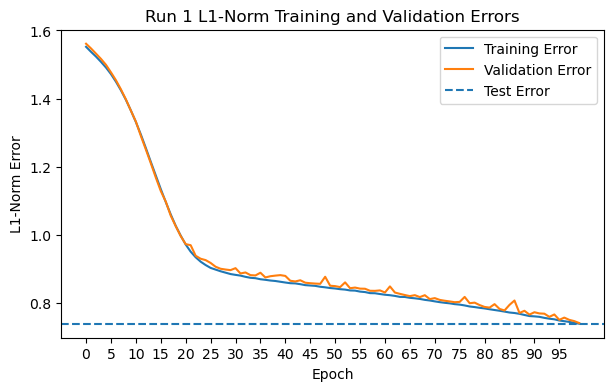


Epoch 1:
Training loss: 3.246, Training prediction error: 1.556
Validation loss: 3.260, Validation prediction error: 1.566

Epoch 2:
Training loss: 3.196, Training prediction error: 1.542
Validation loss: 3.210, Validation prediction error: 1.552

Epoch 3:
Training loss: 3.147, Training prediction error: 1.528
Validation loss: 3.155, Validation prediction error: 1.537

Epoch 4:
Training loss: 3.093, Training prediction error: 1.514
Validation loss: 3.099, Validation prediction error: 1.521

Epoch 5:
Training loss: 3.036, Training prediction error: 1.497
Validation loss: 3.042, Validation prediction error: 1.505

Epoch 6:
Training loss: 2.971, Training prediction error: 1.478
Validation loss: 2.972, Validation prediction error: 1.484

Epoch 7:
Training loss: 2.900, Training prediction error: 1.457
Validation loss: 2.903, Validation prediction error: 1.462

Epoch 8:
Training loss: 2.824, Training prediction error: 1.433
Validation loss: 2.819, Validation prediction error: 1.436

Epoch 9

Training loss: 1.564, Training prediction error: 0.818
Validation loss: 1.586, Validation prediction error: 0.830

Epoch 68:
Training loss: 1.560, Training prediction error: 0.816
Validation loss: 1.603, Validation prediction error: 0.828

Epoch 69:
Training loss: 1.554, Training prediction error: 0.815
Validation loss: 1.580, Validation prediction error: 0.822

Epoch 70:
Training loss: 1.548, Training prediction error: 0.813
Validation loss: 1.568, Validation prediction error: 0.827

Epoch 71:
Training loss: 1.544, Training prediction error: 0.811
Validation loss: 1.561, Validation prediction error: 0.820

Epoch 72:
Training loss: 1.538, Training prediction error: 0.810
Validation loss: 1.556, Validation prediction error: 0.815

Epoch 73:
Training loss: 1.530, Training prediction error: 0.806
Validation loss: 1.608, Validation prediction error: 0.823

Epoch 74:
Training loss: 1.526, Training prediction error: 0.806
Validation loss: 1.554, Validation prediction error: 0.812

Epoch 75:


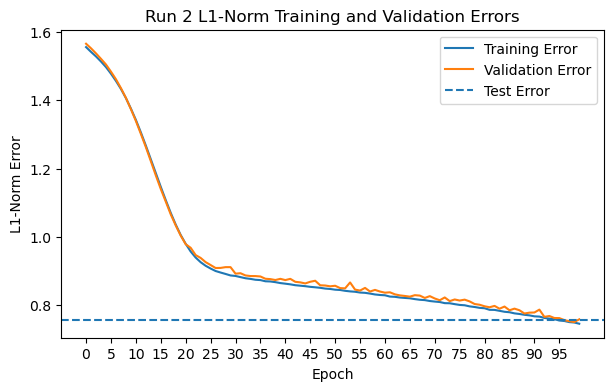


Epoch 1:
Training loss: 3.235, Training prediction error: 1.552
Validation loss: 3.247, Validation prediction error: 1.562

Epoch 2:
Training loss: 3.179, Training prediction error: 1.537
Validation loss: 3.187, Validation prediction error: 1.546

Epoch 3:
Training loss: 3.124, Training prediction error: 1.522
Validation loss: 3.135, Validation prediction error: 1.531

Epoch 4:
Training loss: 3.068, Training prediction error: 1.507
Validation loss: 3.071, Validation prediction error: 1.514

Epoch 5:
Training loss: 3.001, Training prediction error: 1.488
Validation loss: 3.005, Validation prediction error: 1.494

Epoch 6:
Training loss: 2.932, Training prediction error: 1.467
Validation loss: 2.932, Validation prediction error: 1.472

Epoch 7:
Training loss: 2.856, Training prediction error: 1.444
Validation loss: 2.847, Validation prediction error: 1.446

Epoch 8:
Training loss: 2.772, Training prediction error: 1.418
Validation loss: 2.769, Validation prediction error: 1.420

Epoch 9

Training loss: 1.542, Training prediction error: 0.811
Validation loss: 1.557, Validation prediction error: 0.820

Epoch 68:
Training loss: 1.534, Training prediction error: 0.809
Validation loss: 1.556, Validation prediction error: 0.826

Epoch 69:
Training loss: 1.529, Training prediction error: 0.807
Validation loss: 1.548, Validation prediction error: 0.814

Epoch 70:
Training loss: 1.523, Training prediction error: 0.804
Validation loss: 1.561, Validation prediction error: 0.819

Epoch 71:
Training loss: 1.517, Training prediction error: 0.802
Validation loss: 1.542, Validation prediction error: 0.809

Epoch 72:
Training loss: 1.511, Training prediction error: 0.800
Validation loss: 1.560, Validation prediction error: 0.824

Epoch 73:
Training loss: 1.505, Training prediction error: 0.799
Validation loss: 1.527, Validation prediction error: 0.807

Epoch 74:
Training loss: 1.498, Training prediction error: 0.797
Validation loss: 1.510, Validation prediction error: 0.800

Epoch 75:


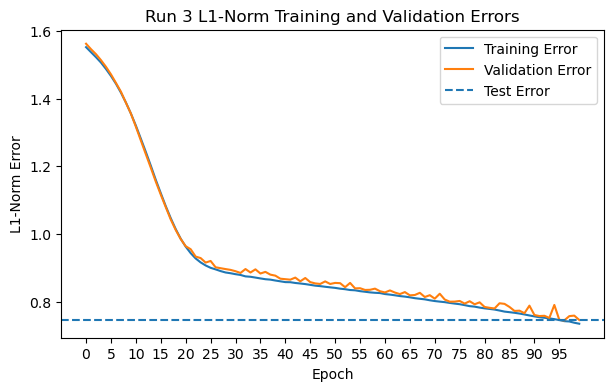


Epoch 1:
Training loss: 3.239, Training prediction error: 1.555
Validation loss: 3.244, Validation prediction error: 1.564

Epoch 2:
Training loss: 3.184, Training prediction error: 1.541
Validation loss: 3.196, Validation prediction error: 1.551

Epoch 3:
Training loss: 3.137, Training prediction error: 1.528
Validation loss: 3.148, Validation prediction error: 1.537

Epoch 4:
Training loss: 3.088, Training prediction error: 1.514
Validation loss: 3.103, Validation prediction error: 1.524

Epoch 5:
Training loss: 3.032, Training prediction error: 1.498
Validation loss: 3.035, Validation prediction error: 1.505

Epoch 6:
Training loss: 2.970, Training prediction error: 1.480
Validation loss: 2.974, Validation prediction error: 1.486

Epoch 7:
Training loss: 2.900, Training prediction error: 1.460
Validation loss: 2.897, Validation prediction error: 1.464

Epoch 8:
Training loss: 2.826, Training prediction error: 1.437
Validation loss: 2.820, Validation prediction error: 1.439

Epoch 9

Training loss: 1.591, Training prediction error: 0.825
Validation loss: 1.613, Validation prediction error: 0.831

Epoch 68:
Training loss: 1.585, Training prediction error: 0.823
Validation loss: 1.605, Validation prediction error: 0.829

Epoch 69:
Training loss: 1.581, Training prediction error: 0.821
Validation loss: 1.599, Validation prediction error: 0.826

Epoch 70:
Training loss: 1.574, Training prediction error: 0.819
Validation loss: 1.602, Validation prediction error: 0.855

Epoch 71:
Training loss: 1.570, Training prediction error: 0.818
Validation loss: 1.602, Validation prediction error: 0.830

Epoch 72:
Training loss: 1.564, Training prediction error: 0.816
Validation loss: 1.590, Validation prediction error: 0.824

Epoch 73:
Training loss: 1.558, Training prediction error: 0.814
Validation loss: 1.584, Validation prediction error: 0.822

Epoch 74:
Training loss: 1.554, Training prediction error: 0.813
Validation loss: 1.571, Validation prediction error: 0.820

Epoch 75:


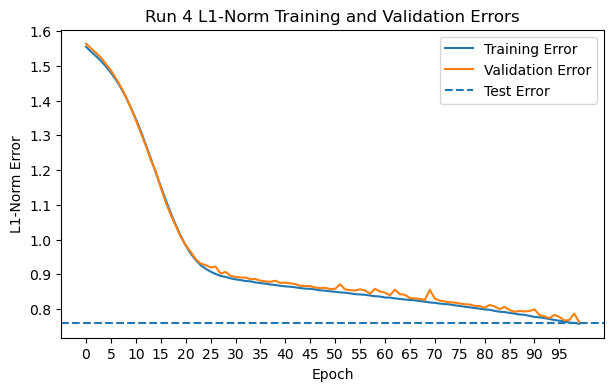


Epoch 1:
Training loss: 3.229, Training prediction error: 1.551
Validation loss: 3.246, Validation prediction error: 1.563

Epoch 2:
Training loss: 3.180, Training prediction error: 1.539
Validation loss: 3.197, Validation prediction error: 1.549

Epoch 3:
Training loss: 3.130, Training prediction error: 1.525
Validation loss: 3.143, Validation prediction error: 1.534

Epoch 4:
Training loss: 3.077, Training prediction error: 1.510
Validation loss: 3.089, Validation prediction error: 1.519

Epoch 5:
Training loss: 3.019, Training prediction error: 1.494
Validation loss: 3.025, Validation prediction error: 1.501

Epoch 6:
Training loss: 2.954, Training prediction error: 1.474
Validation loss: 2.953, Validation prediction error: 1.480

Epoch 7:
Training loss: 2.882, Training prediction error: 1.453
Validation loss: 2.881, Validation prediction error: 1.458

Epoch 8:
Training loss: 2.803, Training prediction error: 1.428
Validation loss: 2.797, Validation prediction error: 1.431

Epoch 9

Training loss: 1.559, Training prediction error: 0.816
Validation loss: 1.580, Validation prediction error: 0.826

Epoch 68:
Training loss: 1.554, Training prediction error: 0.815
Validation loss: 1.584, Validation prediction error: 0.823

Epoch 69:
Training loss: 1.550, Training prediction error: 0.813
Validation loss: 1.573, Validation prediction error: 0.834

Epoch 70:
Training loss: 1.542, Training prediction error: 0.810
Validation loss: 1.560, Validation prediction error: 0.816

Epoch 71:
Training loss: 1.536, Training prediction error: 0.809
Validation loss: 1.554, Validation prediction error: 0.814

Epoch 72:
Training loss: 1.529, Training prediction error: 0.806
Validation loss: 1.548, Validation prediction error: 0.813

Epoch 73:
Training loss: 1.523, Training prediction error: 0.804
Validation loss: 1.546, Validation prediction error: 0.820

Epoch 74:
Training loss: 1.517, Training prediction error: 0.802
Validation loss: 1.538, Validation prediction error: 0.816

Epoch 75:


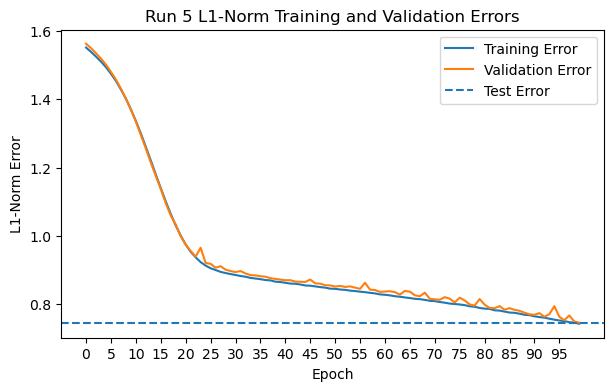


Epoch 1:
Training loss: 3.253, Training prediction error: 1.557
Validation loss: 3.265, Validation prediction error: 1.567

Epoch 2:
Training loss: 3.202, Training prediction error: 1.543
Validation loss: 3.215, Validation prediction error: 1.553

Epoch 3:
Training loss: 3.154, Training prediction error: 1.531
Validation loss: 3.165, Validation prediction error: 1.540

Epoch 4:
Training loss: 3.103, Training prediction error: 1.517
Validation loss: 3.111, Validation prediction error: 1.525

Epoch 5:
Training loss: 3.049, Training prediction error: 1.501
Validation loss: 3.052, Validation prediction error: 1.508

Epoch 6:
Training loss: 2.989, Training prediction error: 1.484
Validation loss: 2.989, Validation prediction error: 1.490

Epoch 7:
Training loss: 2.920, Training prediction error: 1.464
Validation loss: 2.918, Validation prediction error: 1.468

Epoch 8:
Training loss: 2.845, Training prediction error: 1.441
Validation loss: 2.840, Validation prediction error: 1.444

Epoch 9

Training loss: 1.587, Training prediction error: 0.823
Validation loss: 1.615, Validation prediction error: 0.858

Epoch 68:
Training loss: 1.578, Training prediction error: 0.820
Validation loss: 1.607, Validation prediction error: 0.827

Epoch 69:
Training loss: 1.574, Training prediction error: 0.819
Validation loss: 1.597, Validation prediction error: 0.830

Epoch 70:
Training loss: 1.568, Training prediction error: 0.817
Validation loss: 1.593, Validation prediction error: 0.825

Epoch 71:
Training loss: 1.563, Training prediction error: 0.816
Validation loss: 1.582, Validation prediction error: 0.823

Epoch 72:
Training loss: 1.558, Training prediction error: 0.814
Validation loss: 1.590, Validation prediction error: 0.821

Epoch 73:
Training loss: 1.552, Training prediction error: 0.813
Validation loss: 1.580, Validation prediction error: 0.834

Epoch 74:
Training loss: 1.547, Training prediction error: 0.811
Validation loss: 1.568, Validation prediction error: 0.833

Epoch 75:


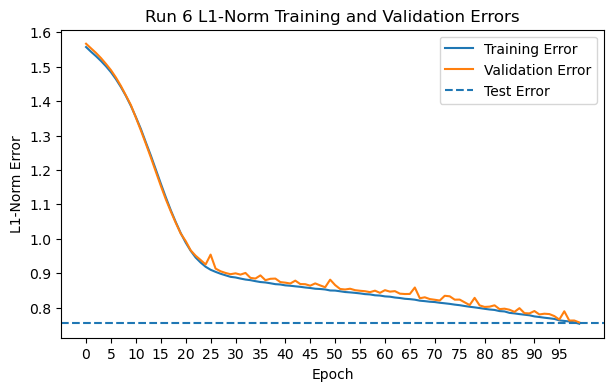


Epoch 1:
Training loss: 3.229, Training prediction error: 1.551
Validation loss: 3.249, Validation prediction error: 1.563

Epoch 2:
Training loss: 3.183, Training prediction error: 1.539
Validation loss: 3.197, Validation prediction error: 1.549

Epoch 3:
Training loss: 3.139, Training prediction error: 1.527
Validation loss: 3.150, Validation prediction error: 1.536

Epoch 4:
Training loss: 3.089, Training prediction error: 1.513
Validation loss: 3.098, Validation prediction error: 1.522

Epoch 5:
Training loss: 3.034, Training prediction error: 1.497
Validation loss: 3.042, Validation prediction error: 1.505

Epoch 6:
Training loss: 2.974, Training prediction error: 1.480
Validation loss: 2.983, Validation prediction error: 1.487

Epoch 7:
Training loss: 2.908, Training prediction error: 1.460
Validation loss: 2.908, Validation prediction error: 1.465

Epoch 8:
Training loss: 2.832, Training prediction error: 1.437
Validation loss: 2.831, Validation prediction error: 1.441

Epoch 9

Training loss: 1.566, Training prediction error: 0.817
Validation loss: 1.585, Validation prediction error: 0.828

Epoch 68:
Training loss: 1.560, Training prediction error: 0.815
Validation loss: 1.588, Validation prediction error: 0.830

Epoch 69:
Training loss: 1.554, Training prediction error: 0.814
Validation loss: 1.576, Validation prediction error: 0.820

Epoch 70:
Training loss: 1.547, Training prediction error: 0.811
Validation loss: 1.568, Validation prediction error: 0.818

Epoch 71:
Training loss: 1.541, Training prediction error: 0.809
Validation loss: 1.570, Validation prediction error: 0.840

Epoch 72:
Training loss: 1.539, Training prediction error: 0.807
Validation loss: 1.553, Validation prediction error: 0.812

Epoch 73:
Training loss: 1.529, Training prediction error: 0.805
Validation loss: 1.551, Validation prediction error: 0.832

Epoch 74:
Training loss: 1.522, Training prediction error: 0.802
Validation loss: 1.541, Validation prediction error: 0.809

Epoch 75:


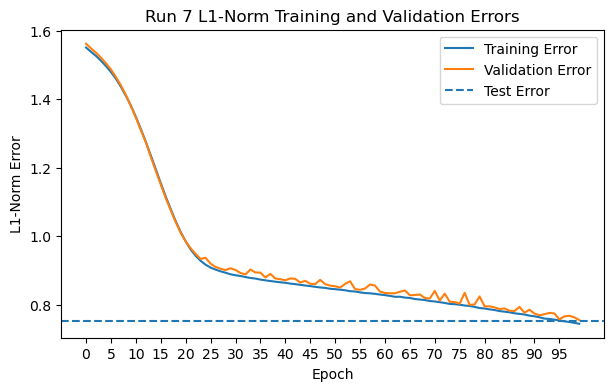


Epoch 1:
Training loss: 3.245, Training prediction error: 1.557
Validation loss: 3.250, Validation prediction error: 1.565

Epoch 2:
Training loss: 3.186, Training prediction error: 1.541
Validation loss: 3.193, Validation prediction error: 1.550

Epoch 3:
Training loss: 3.130, Training prediction error: 1.526
Validation loss: 3.137, Validation prediction error: 1.534

Epoch 4:
Training loss: 3.072, Training prediction error: 1.509
Validation loss: 3.074, Validation prediction error: 1.516

Epoch 5:
Training loss: 3.007, Training prediction error: 1.491
Validation loss: 3.009, Validation prediction error: 1.497

Epoch 6:
Training loss: 2.937, Training prediction error: 1.470
Validation loss: 2.940, Validation prediction error: 1.476

Epoch 7:
Training loss: 2.859, Training prediction error: 1.447
Validation loss: 2.856, Validation prediction error: 1.451

Epoch 8:
Training loss: 2.777, Training prediction error: 1.421
Validation loss: 2.766, Validation prediction error: 1.422

Epoch 9

Training loss: 1.545, Training prediction error: 0.812
Validation loss: 1.564, Validation prediction error: 0.821

Epoch 68:
Training loss: 1.539, Training prediction error: 0.810
Validation loss: 1.561, Validation prediction error: 0.828

Epoch 69:
Training loss: 1.534, Training prediction error: 0.809
Validation loss: 1.569, Validation prediction error: 0.816

Epoch 70:
Training loss: 1.522, Training prediction error: 0.804
Validation loss: 1.541, Validation prediction error: 0.810

Epoch 71:
Training loss: 1.520, Training prediction error: 0.803
Validation loss: 1.548, Validation prediction error: 0.812

Epoch 72:
Training loss: 1.512, Training prediction error: 0.801
Validation loss: 1.544, Validation prediction error: 0.817

Epoch 73:
Training loss: 1.507, Training prediction error: 0.800
Validation loss: 1.535, Validation prediction error: 0.806

Epoch 74:
Training loss: 1.501, Training prediction error: 0.797
Validation loss: 1.517, Validation prediction error: 0.804

Epoch 75:


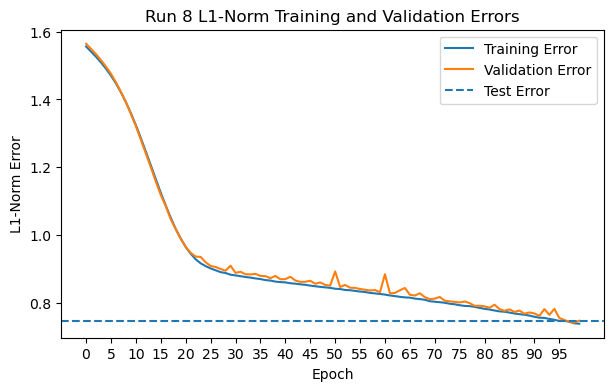


Epoch 1:
Training loss: 3.233, Training prediction error: 1.554
Validation loss: 3.242, Validation prediction error: 1.563

Epoch 2:
Training loss: 3.180, Training prediction error: 1.540
Validation loss: 3.190, Validation prediction error: 1.549

Epoch 3:
Training loss: 3.125, Training prediction error: 1.525
Validation loss: 3.137, Validation prediction error: 1.534

Epoch 4:
Training loss: 3.067, Training prediction error: 1.509
Validation loss: 3.080, Validation prediction error: 1.518

Epoch 5:
Training loss: 3.003, Training prediction error: 1.491
Validation loss: 3.006, Validation prediction error: 1.496

Epoch 6:
Training loss: 2.934, Training prediction error: 1.470
Validation loss: 2.935, Validation prediction error: 1.476

Epoch 7:
Training loss: 2.859, Training prediction error: 1.448
Validation loss: 2.854, Validation prediction error: 1.451

Epoch 8:
Training loss: 2.775, Training prediction error: 1.421
Validation loss: 2.766, Validation prediction error: 1.422

Epoch 9

Training loss: 1.575, Training prediction error: 0.820
Validation loss: 1.598, Validation prediction error: 0.826

Epoch 68:
Training loss: 1.571, Training prediction error: 0.818
Validation loss: 1.598, Validation prediction error: 0.836

Epoch 69:
Training loss: 1.564, Training prediction error: 0.816
Validation loss: 1.592, Validation prediction error: 0.823

Epoch 70:
Training loss: 1.558, Training prediction error: 0.815
Validation loss: 1.590, Validation prediction error: 0.822

Epoch 71:
Training loss: 1.553, Training prediction error: 0.812
Validation loss: 1.574, Validation prediction error: 0.820

Epoch 72:
Training loss: 1.549, Training prediction error: 0.811
Validation loss: 1.568, Validation prediction error: 0.823

Epoch 73:
Training loss: 1.543, Training prediction error: 0.809
Validation loss: 1.577, Validation prediction error: 0.818

Epoch 74:
Training loss: 1.535, Training prediction error: 0.806
Validation loss: 1.555, Validation prediction error: 0.813

Epoch 75:


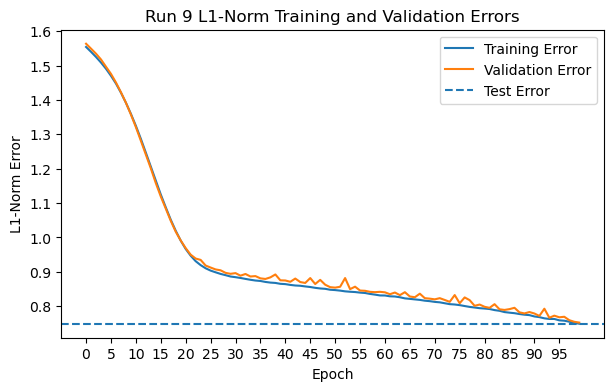


Epoch 1:
Training loss: 3.234, Training prediction error: 1.551
Validation loss: 3.247, Validation prediction error: 1.561

Epoch 2:
Training loss: 3.186, Training prediction error: 1.538
Validation loss: 3.206, Validation prediction error: 1.550

Epoch 3:
Training loss: 3.143, Training prediction error: 1.527
Validation loss: 3.158, Validation prediction error: 1.538

Epoch 4:
Training loss: 3.096, Training prediction error: 1.514
Validation loss: 3.106, Validation prediction error: 1.523

Epoch 5:
Training loss: 3.042, Training prediction error: 1.498
Validation loss: 3.047, Validation prediction error: 1.506

Epoch 6:
Training loss: 2.981, Training prediction error: 1.481
Validation loss: 2.989, Validation prediction error: 1.489

Epoch 7:
Training loss: 2.913, Training prediction error: 1.461
Validation loss: 2.915, Validation prediction error: 1.467

Epoch 8:
Training loss: 2.839, Training prediction error: 1.438
Validation loss: 2.838, Validation prediction error: 1.442

Epoch 9

Training loss: 1.571, Training prediction error: 0.821
Validation loss: 1.597, Validation prediction error: 0.831

Epoch 68:
Training loss: 1.566, Training prediction error: 0.819
Validation loss: 1.585, Validation prediction error: 0.828

Epoch 69:
Training loss: 1.557, Training prediction error: 0.817
Validation loss: 1.589, Validation prediction error: 0.825

Epoch 70:
Training loss: 1.553, Training prediction error: 0.814
Validation loss: 1.576, Validation prediction error: 0.822

Epoch 71:
Training loss: 1.549, Training prediction error: 0.813
Validation loss: 1.577, Validation prediction error: 0.821

Epoch 72:
Training loss: 1.542, Training prediction error: 0.811
Validation loss: 1.564, Validation prediction error: 0.819

Epoch 73:
Training loss: 1.537, Training prediction error: 0.810
Validation loss: 1.553, Validation prediction error: 0.815

Epoch 74:
Training loss: 1.530, Training prediction error: 0.808
Validation loss: 1.556, Validation prediction error: 0.828

Epoch 75:


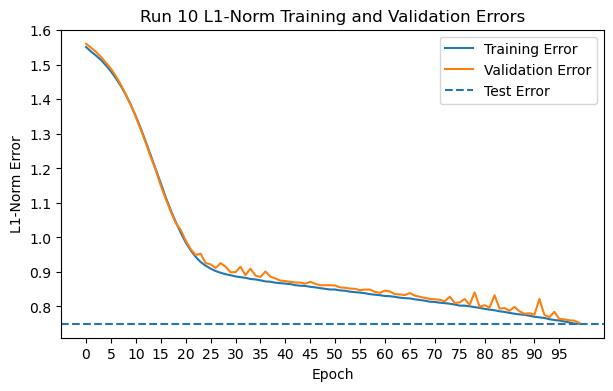

average prediction error:  0.7494392834545005


In [12]:
# Hyperparameter constants
LEARNING_RATE_THETA = 2.0e-4
NUM_EPOCHS_THETA = 100
NUM_RUNS_THETA = 10

if not AUTOGRADING:
    """TASK 1.1: TRAIN MODEL HERE"""
    predictionErrorTheta = onp.zeros((NUM_RUNS_THETA))

    for run in onp.arange(NUM_RUNS_THETA):
        # this code reinitializes the parameters of the model on each loop
        model_theta = torch.jit.script(NeuralNetworkTheta().to(DEVICE))
        optimizerTheta = torch.optim.SGD(model_theta.parameters(), lr=LEARNING_RATE_THETA)
        
        # YOUR CODE HERE
        
        epochErrorHistoryTheta = runTraining(
            model_theta,
            optimizerTheta,
            NUM_EPOCHS_THETA,
            train_loader_theta,
            val_loader_theta,
            evaluateRunningModel,
        )
        print(f"\n###############################################################################################")
        print(f"run {run+1} finished!")
        predictionErrorTheta[run] = evaluateRunningModel(model_theta, test_loader_theta, "Test")
        print(f"###############################################################################################\n")
        lowEffortPlot(epochErrorHistoryTheta, predictionErrorTheta[run], NUM_EPOCHS_THETA)
        
    print("average prediction error: ", onp.mean(predictionErrorTheta))
    """TASK 1.1: END"""

Mean prediction error across bins: 0.7471515427803911


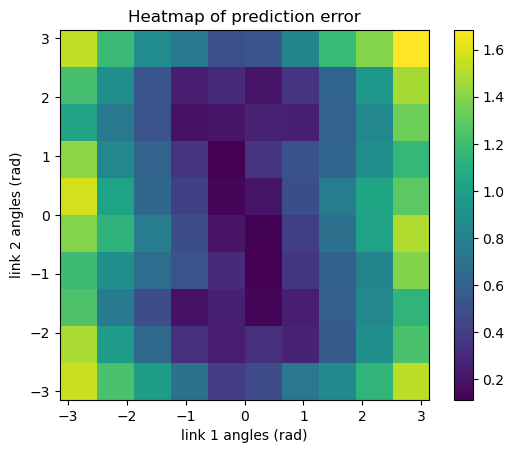

In [13]:
if not AUTOGRADING:
    model_theta_scripted = torch.jit.script(model_theta)
    model_theta_scripted.save(str(statedicts_dir / "task_1-1_model_theta.pt"))
    
    evaluate_model(
        model_theta,
        test_dataset_theta,
        model="theta",
        file="task_1-1_model_theta_prediction_error.pdf",
    )

### 1.1 - Analyse Model performance (4p)
Analyze the prediction accuracy of the model on the test data from heat map of the loss outputted from the `evaluate_model` function. Where does this model have the lowest accuracy? What could be an explanation for the loss of accuracy in those regions? **2p** (Answer in the cell below)

YOUR ANSWER HERE

Two main things should come to mind when seeing a result like this (there are of course as always with NNs many more things...). 

1: is the training dataset heavily imbalanced, and if so is it imbalanced in such a way that it explains the result? Are there fewer samples of the classes, or in this case angle values, that are not being predicted well?

2: Is there something about the function we are trying to approximate that makes certain cases difficult? If you can identify those cases (certainly not always feasible), again, do they explain the results?

In this case, as can be seen in **task_1a_generate_data.ipynb**, there are angle-pair values in the training set with about 2x as many samples as the ones with the lowest amount of samples, but these samples do **not** appear to my human eyes to be correlated with the test results to a large degree. 

With that in mind we go looking at what the function we are trying to approximate is. We are predicting angles of a double pendulum in a 2D cartesian coordinate space, and quoting Task 1.0 in **task_1a_generate_data.ipynb**: "The angle $\theta_1$ of link 1 and $\theta_2$ of link 2 are both defined with respect to the right horizontal position (or x-axis), both are wrapped to the $[-\pi, \pi]$ domain." 

This means we are approximating some function that takes as input an image and outputs a cyclic value. In other words, the function we are appoximating is cyclic. Not only that, the function has jump discontinuities at $f(\mathbf{x}) = -\pi,\pi$. This means the universal approximation theorem does not apply, but more intuitively, any gradient based nonlinear optimization struggles with jump discontinuities, and as such from a practical point of view we expect to see larger errors close to these points in our output space.

In general, a separate test dataset is used to evaluate a trained model. Why? **(2p)** (Answer in the cell below)

YOUR ANSWER HERE

Going to assume train-validate-test convention as opposed to train-test-validate for this question. Not that it matters that much, since the reasoning for both is to avoid overfitting, only one with respect to the model parameters, and the other with respect to the model hyperparameters (which are also just fundamentally parameters). 

In general (and there are always caveats) you need to separate training from testing because the usefulness of your model depends on its generalization ability to the types of data it will face in deployment/use. The key thing to realize here is that this data is not something you generally have access to (in its entirety), so while your validation dataset is used to evaluate you model to prevent overfitting to the training dataset during training, you will also be iterating on your hyperparameters based on this evaluation. What can you then say about the performance it will have after deployment? Nothing, unless you evaluate the final iteration on a completely separate dataset, the test set (which *should* be representative of actual data your model will face). This then tells you whether your hyperparameters are overfit to the train-validate procedure (*in a sense* overfit to the similarity between you training and validation sets), and you will avoid a nasty surprise when your model does not perform as well in the real world as it did during validation. As a side note, its very easy to inadvertently 'cheat' and report better results than you can actually be confident in, precisely because the 'human in the loop' overfit their model in this way.

## Task 1.2: Indirectly predict the angle
We are going to improve the accuracy by pre-processing the target data. Specifically, we will create a model $M_{trig}$ that learns to predict $\sin(\theta)$ and $\cos(\theta)$ for both links instead of directly predicting $\theta$. Then, we can use the trigonometric relation to retrieve an estimate of $\theta$ for both links.

Note: In practice you would use the `atan2` implementation, as the regular arctangent only covers $[-\frac{1}{2}\pi, \frac{1}{2}\pi]$} $\theta=\arctan(\frac{\sin(\theta)}{\cos(\theta)})$ 

### 1.2 Prepare the data (0p)

Run the functions below to load the data generated in `task_1a_generate_data.ipynb`, split the training into the 70/30 train/validation split, set the batch size to and put them in a dataloader. The data is first put in the class `TrigDataset`. This class again converts the `uint8` pixel values from a range of 0-255 to float values in the range `0-1` while also calculating the values of $\mathrm{sin}(\theta_1), \mathrm{sin}(\theta_2), \mathrm{cos}(\theta_1), \mathrm{cos}(\theta_2)$ to be used as labels instead of just $\theta_1, \theta_2$ as was done in the `ThetaDataset` class. The dataloader is again set to shuffle the data randomly before enumerating during the training loop.

In [14]:
if not AUTOGRADING:
    train_loader_trig, val_loader_trig = load_training_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_train.npz",
        _rng=init_rng,
        model_type="trig",
    )
    test_loader_trig, test_dataset_trig = load_test_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_test.npz",
        _rng=init_rng,
        model_type="trig",
    )

Trig Dataset


### 1.2 - Create the model (1.5p)

Copy the model you created in Task 1.1. Change the number of hidden units of the final layer from 2 to 4. We do so, because we now want to predict two outputs ($\sin(\theta)$, $\cos(\theta)$) for both link angles, instead of only two outputs, $\theta_1$ and $\theta_2$.

In [15]:
""" TASK 1.2: CREATE MODEL HERE """

INPUT_SHAPE_TRIG = int(onp.prod(next(iter(train_loader_trig))[0].size()[1::]))
print("\nSamples have flattened shape:", INPUT_SHAPE_TRIG)

class NeuralNetworkTrig(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
        self.layer1 = torch.nn.Flatten()
        self.layer2 = torch.nn.Linear(INPUT_SHAPE_TRIG, 128)
        self.layer3 = torch.nn.Linear(128, 4)
        
    def forward(self, x):
        return self.layer3(torch.nn.functional.relu(self.layer2(self.layer1(x))))

"""TASK1.2: END"""

model_trig = torch.jit.script(NeuralNetworkTrig().to(DEVICE))
total_params_trig = sum(p.numel() for p in model_trig.parameters())
print("Total number of neural network parameters: ", total_params_trig)


Samples have flattened shape: 3072
Total number of neural network parameters:  393860


### 1.2 - Train the model (2p)

Now train a model with the same training parameters defined below as in task 1.1 but using the training data `train_loader_trig`. Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 100 epochs. Do this 10 times and record the prediction error of the final model of each of the 10 runs on the test dataset `test_loader_trig` using the function `evaluate_model_test_data_trig`. **Hint:** 
- reduce the number of epochs and lower the number of runs to `1` while getting your model working. 
- The try in the range `1e-1` to `1e-5` for the learning rate


Epoch 1:
Training loss: 5.752, Training prediction error: 1.864
Validation loss: 4.692, Validation prediction error: 1.617

Epoch 2:
Training loss: 5.026, Training prediction error: 1.633
Validation loss: 5.015, Validation prediction error: 1.603

Epoch 3:
Training loss: 4.707, Training prediction error: 1.509
Validation loss: 4.814, Validation prediction error: 1.500

Epoch 4:
Training loss: 4.434, Training prediction error: 1.407
Validation loss: 4.355, Validation prediction error: 1.360

Epoch 5:
Training loss: 4.094, Training prediction error: 1.318
Validation loss: 4.721, Validation prediction error: 1.415

Epoch 6:
Training loss: 4.081, Training prediction error: 1.292
Validation loss: 3.712, Validation prediction error: 1.200

Epoch 7:
Training loss: 3.881, Training prediction error: 1.239
Validation loss: 3.982, Validation prediction error: 1.238

Epoch 8:
Training loss: 3.893, Training prediction error: 1.226
Validation loss: 3.960, Validation prediction error: 1.258

Epoch 9

Training loss: 2.350, Training prediction error: 0.753
Validation loss: 2.039, Validation prediction error: 0.707

Epoch 68:
Training loss: 2.363, Training prediction error: 0.753
Validation loss: 2.572, Validation prediction error: 0.794

Epoch 69:
Training loss: 2.337, Training prediction error: 0.749
Validation loss: 2.125, Validation prediction error: 0.709

Epoch 70:
Training loss: 2.364, Training prediction error: 0.750
Validation loss: 2.207, Validation prediction error: 0.718

Epoch 71:
Training loss: 2.289, Training prediction error: 0.736
Validation loss: 2.574, Validation prediction error: 0.781

Epoch 72:
Training loss: 2.374, Training prediction error: 0.753
Validation loss: 2.266, Validation prediction error: 0.724

Epoch 73:
Training loss: 2.325, Training prediction error: 0.741
Validation loss: 1.937, Validation prediction error: 0.698

Epoch 74:
Training loss: 2.289, Training prediction error: 0.733
Validation loss: 2.097, Validation prediction error: 0.699

Epoch 75:


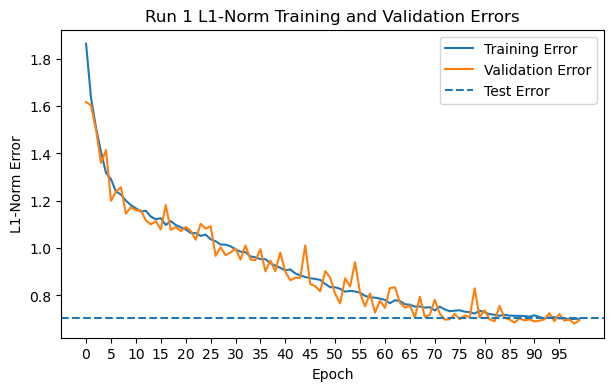


Epoch 1:
Training loss: 5.511, Training prediction error: 1.928
Validation loss: 6.572, Validation prediction error: 2.065

Epoch 2:
Training loss: 5.560, Training prediction error: 1.843
Validation loss: 5.396, Validation prediction error: 1.781

Epoch 3:
Training loss: 4.873, Training prediction error: 1.632
Validation loss: 4.248, Validation prediction error: 1.514

Epoch 4:
Training loss: 4.489, Training prediction error: 1.501
Validation loss: 3.543, Validation prediction error: 1.304

Epoch 5:
Training loss: 4.232, Training prediction error: 1.394
Validation loss: 3.091, Validation prediction error: 1.188

Epoch 6:
Training loss: 3.912, Training prediction error: 1.300
Validation loss: 3.029, Validation prediction error: 1.128

Epoch 7:
Training loss: 3.853, Training prediction error: 1.262
Validation loss: 3.093, Validation prediction error: 1.145

Epoch 8:
Training loss: 3.661, Training prediction error: 1.207
Validation loss: 4.814, Validation prediction error: 1.408

Epoch 9

Training loss: 2.866, Training prediction error: 0.874
Validation loss: 2.936, Validation prediction error: 0.873

Epoch 68:
Training loss: 2.850, Training prediction error: 0.867
Validation loss: 2.482, Validation prediction error: 0.808

Epoch 69:
Training loss: 2.776, Training prediction error: 0.852
Validation loss: 3.059, Validation prediction error: 0.895

Epoch 70:
Training loss: 2.828, Training prediction error: 0.859
Validation loss: 2.830, Validation prediction error: 0.858

Epoch 71:
Training loss: 2.776, Training prediction error: 0.848
Validation loss: 2.395, Validation prediction error: 0.785

Epoch 72:
Training loss: 2.721, Training prediction error: 0.834
Validation loss: 2.754, Validation prediction error: 0.842

Epoch 73:
Training loss: 2.735, Training prediction error: 0.835
Validation loss: 2.306, Validation prediction error: 0.776

Epoch 74:
Training loss: 2.651, Training prediction error: 0.817
Validation loss: 2.740, Validation prediction error: 0.827

Epoch 75:


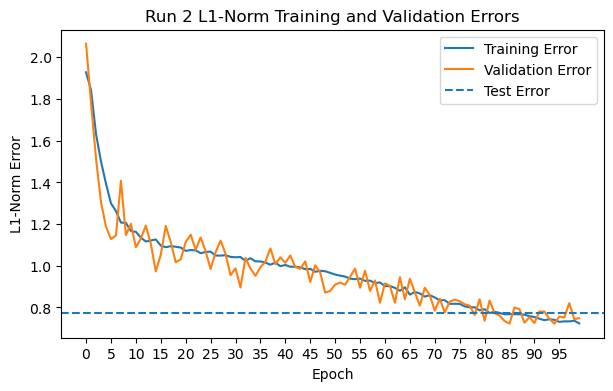


Epoch 1:
Training loss: 5.564, Training prediction error: 1.805
Validation loss: 5.916, Validation prediction error: 1.767

Epoch 2:
Training loss: 4.889, Training prediction error: 1.574
Validation loss: 5.129, Validation prediction error: 1.581

Epoch 3:
Training loss: 4.483, Training prediction error: 1.441
Validation loss: 3.674, Validation prediction error: 1.297

Epoch 4:
Training loss: 4.135, Training prediction error: 1.350
Validation loss: 4.605, Validation prediction error: 1.377

Epoch 5:
Training loss: 4.011, Training prediction error: 1.287
Validation loss: 3.539, Validation prediction error: 1.193

Epoch 6:
Training loss: 3.784, Training prediction error: 1.229
Validation loss: 4.316, Validation prediction error: 1.281

Epoch 7:
Training loss: 3.796, Training prediction error: 1.212
Validation loss: 2.896, Validation prediction error: 1.061

Epoch 8:
Training loss: 3.633, Training prediction error: 1.171
Validation loss: 3.122, Validation prediction error: 1.093

Epoch 9

Training loss: 2.714, Training prediction error: 0.839
Validation loss: 2.613, Validation prediction error: 0.816

Epoch 68:
Training loss: 2.690, Training prediction error: 0.830
Validation loss: 2.829, Validation prediction error: 0.870

Epoch 69:
Training loss: 2.677, Training prediction error: 0.825
Validation loss: 2.856, Validation prediction error: 0.855

Epoch 70:
Training loss: 2.694, Training prediction error: 0.826
Validation loss: 2.990, Validation prediction error: 0.876

Epoch 71:
Training loss: 2.634, Training prediction error: 0.814
Validation loss: 2.701, Validation prediction error: 0.820

Epoch 72:
Training loss: 2.616, Training prediction error: 0.807
Validation loss: 2.619, Validation prediction error: 0.812

Epoch 73:
Training loss: 2.604, Training prediction error: 0.804
Validation loss: 2.932, Validation prediction error: 0.863

Epoch 74:
Training loss: 2.602, Training prediction error: 0.801
Validation loss: 2.192, Validation prediction error: 0.747

Epoch 75:


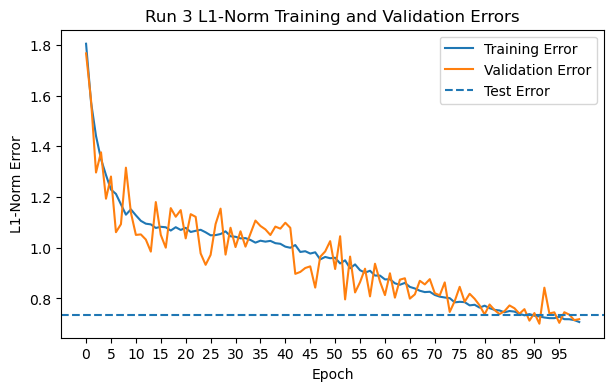


Epoch 1:
Training loss: 6.903, Training prediction error: 2.091
Validation loss: 7.540, Validation prediction error: 2.113

Epoch 2:
Training loss: 5.725, Training prediction error: 1.785
Validation loss: 5.599, Validation prediction error: 1.739

Epoch 3:
Training loss: 5.160, Training prediction error: 1.613
Validation loss: 6.911, Validation prediction error: 1.840

Epoch 4:
Training loss: 5.033, Training prediction error: 1.529
Validation loss: 4.317, Validation prediction error: 1.386

Epoch 5:
Training loss: 4.635, Training prediction error: 1.418
Validation loss: 3.673, Validation prediction error: 1.279

Epoch 6:
Training loss: 4.371, Training prediction error: 1.352
Validation loss: 5.159, Validation prediction error: 1.452

Epoch 7:
Training loss: 4.417, Training prediction error: 1.334
Validation loss: 4.215, Validation prediction error: 1.297

Epoch 8:
Training loss: 4.327, Training prediction error: 1.304
Validation loss: 3.378, Validation prediction error: 1.138

Epoch 9

Training loss: 2.485, Training prediction error: 0.774
Validation loss: 2.637, Validation prediction error: 0.807

Epoch 68:
Training loss: 2.525, Training prediction error: 0.783
Validation loss: 2.207, Validation prediction error: 0.722

Epoch 69:
Training loss: 2.516, Training prediction error: 0.779
Validation loss: 2.232, Validation prediction error: 0.725

Epoch 70:
Training loss: 2.464, Training prediction error: 0.766
Validation loss: 2.446, Validation prediction error: 0.760

Epoch 71:
Training loss: 2.510, Training prediction error: 0.774
Validation loss: 2.383, Validation prediction error: 0.749

Epoch 72:
Training loss: 2.455, Training prediction error: 0.763
Validation loss: 1.931, Validation prediction error: 0.686

Epoch 73:
Training loss: 2.437, Training prediction error: 0.758
Validation loss: 2.337, Validation prediction error: 0.739

Epoch 74:
Training loss: 2.486, Training prediction error: 0.766
Validation loss: 1.897, Validation prediction error: 0.686

Epoch 75:


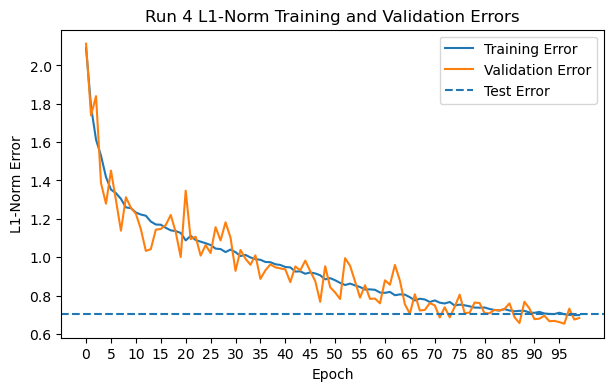


Epoch 1:
Training loss: 5.728, Training prediction error: 1.879
Validation loss: 6.135, Validation prediction error: 1.867

Epoch 2:
Training loss: 5.912, Training prediction error: 1.789
Validation loss: 5.547, Validation prediction error: 1.684

Epoch 3:
Training loss: 5.506, Training prediction error: 1.654
Validation loss: 4.810, Validation prediction error: 1.508

Epoch 4:
Training loss: 5.086, Training prediction error: 1.533
Validation loss: 4.454, Validation prediction error: 1.392

Epoch 5:
Training loss: 4.800, Training prediction error: 1.443
Validation loss: 4.807, Validation prediction error: 1.443

Epoch 6:
Training loss: 4.637, Training prediction error: 1.396
Validation loss: 3.866, Validation prediction error: 1.230

Epoch 7:
Training loss: 4.270, Training prediction error: 1.298
Validation loss: 4.568, Validation prediction error: 1.323

Epoch 8:
Training loss: 4.402, Training prediction error: 1.309
Validation loss: 2.854, Validation prediction error: 1.054

Epoch 9

Training loss: 2.896, Training prediction error: 0.858
Validation loss: 2.929, Validation prediction error: 0.859

Epoch 68:
Training loss: 2.841, Training prediction error: 0.847
Validation loss: 3.063, Validation prediction error: 0.881

Epoch 69:
Training loss: 2.867, Training prediction error: 0.855
Validation loss: 3.119, Validation prediction error: 0.895

Epoch 70:
Training loss: 2.849, Training prediction error: 0.845
Validation loss: 2.972, Validation prediction error: 0.862

Epoch 71:
Training loss: 2.801, Training prediction error: 0.836
Validation loss: 2.871, Validation prediction error: 0.843

Epoch 72:
Training loss: 2.849, Training prediction error: 0.845
Validation loss: 2.804, Validation prediction error: 0.835

Epoch 73:
Training loss: 2.756, Training prediction error: 0.826
Validation loss: 3.257, Validation prediction error: 0.917

Epoch 74:
Training loss: 2.791, Training prediction error: 0.829
Validation loss: 2.704, Validation prediction error: 0.811

Epoch 75:


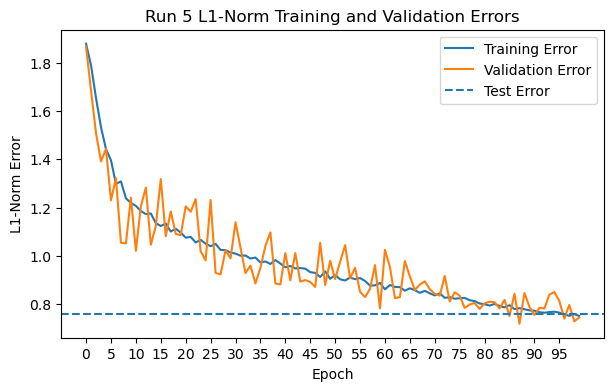


Epoch 1:
Training loss: 5.148, Training prediction error: 1.765
Validation loss: 4.706, Validation prediction error: 1.630

Epoch 2:
Training loss: 4.748, Training prediction error: 1.602
Validation loss: 3.679, Validation prediction error: 1.399

Epoch 3:
Training loss: 4.543, Training prediction error: 1.504
Validation loss: 3.547, Validation prediction error: 1.296

Epoch 4:
Training loss: 4.342, Training prediction error: 1.406
Validation loss: 5.959, Validation prediction error: 1.638

Epoch 5:
Training loss: 4.448, Training prediction error: 1.387
Validation loss: 3.222, Validation prediction error: 1.177

Epoch 6:
Training loss: 4.226, Training prediction error: 1.326
Validation loss: 4.533, Validation prediction error: 1.341

Epoch 7:
Training loss: 4.267, Training prediction error: 1.310
Validation loss: 3.780, Validation prediction error: 1.216

Epoch 8:
Training loss: 4.189, Training prediction error: 1.276
Validation loss: 4.810, Validation prediction error: 1.361

Epoch 9

Training loss: 2.995, Training prediction error: 0.860
Validation loss: 2.600, Validation prediction error: 0.800

Epoch 68:
Training loss: 2.967, Training prediction error: 0.854
Validation loss: 2.633, Validation prediction error: 0.810

Epoch 69:
Training loss: 2.971, Training prediction error: 0.850
Validation loss: 2.900, Validation prediction error: 0.836

Epoch 70:
Training loss: 2.907, Training prediction error: 0.842
Validation loss: 3.156, Validation prediction error: 0.872

Epoch 71:
Training loss: 2.953, Training prediction error: 0.848
Validation loss: 3.139, Validation prediction error: 0.875

Epoch 72:
Training loss: 2.936, Training prediction error: 0.841
Validation loss: 2.926, Validation prediction error: 0.841

Epoch 73:
Training loss: 2.881, Training prediction error: 0.835
Validation loss: 2.852, Validation prediction error: 0.820

Epoch 74:
Training loss: 2.910, Training prediction error: 0.833
Validation loss: 2.923, Validation prediction error: 0.833

Epoch 75:


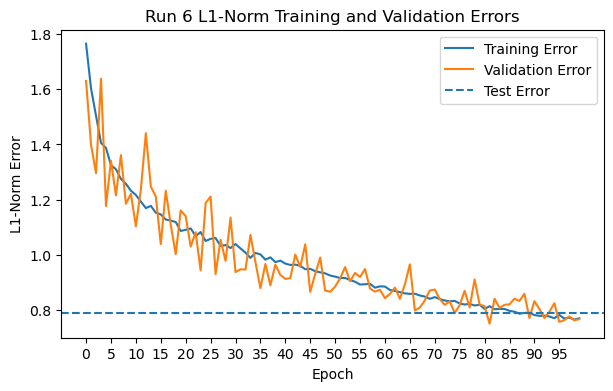


Epoch 1:
Training loss: 5.489, Training prediction error: 1.860
Validation loss: 5.415, Validation prediction error: 1.769

Epoch 2:
Training loss: 5.260, Training prediction error: 1.715
Validation loss: 4.679, Validation prediction error: 1.555

Epoch 3:
Training loss: 4.825, Training prediction error: 1.558
Validation loss: 5.171, Validation prediction error: 1.652

Epoch 4:
Training loss: 4.526, Training prediction error: 1.447
Validation loss: 5.997, Validation prediction error: 1.674

Epoch 5:
Training loss: 4.388, Training prediction error: 1.376
Validation loss: 4.601, Validation prediction error: 1.362

Epoch 6:
Training loss: 4.229, Training prediction error: 1.316
Validation loss: 4.023, Validation prediction error: 1.288

Epoch 7:
Training loss: 4.051, Training prediction error: 1.269
Validation loss: 5.206, Validation prediction error: 1.433

Epoch 8:
Training loss: 4.163, Training prediction error: 1.261
Validation loss: 3.388, Validation prediction error: 1.116

Epoch 9

Training loss: 2.649, Training prediction error: 0.798
Validation loss: 2.858, Validation prediction error: 0.827

Epoch 68:
Training loss: 2.724, Training prediction error: 0.808
Validation loss: 2.354, Validation prediction error: 0.751

Epoch 69:
Training loss: 2.624, Training prediction error: 0.789
Validation loss: 2.997, Validation prediction error: 0.857

Epoch 70:
Training loss: 2.671, Training prediction error: 0.796
Validation loss: 2.424, Validation prediction error: 0.753

Epoch 71:
Training loss: 2.604, Training prediction error: 0.782
Validation loss: 2.515, Validation prediction error: 0.773

Epoch 72:
Training loss: 2.580, Training prediction error: 0.778
Validation loss: 2.629, Validation prediction error: 0.780

Epoch 73:
Training loss: 2.566, Training prediction error: 0.772
Validation loss: 2.794, Validation prediction error: 0.818

Epoch 74:
Training loss: 2.633, Training prediction error: 0.784
Validation loss: 2.216, Validation prediction error: 0.720

Epoch 75:


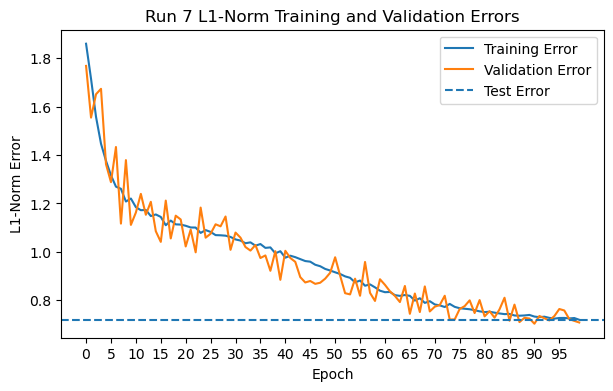


Epoch 1:
Training loss: 6.444, Training prediction error: 1.945
Validation loss: 4.000, Validation prediction error: 1.577

Epoch 2:
Training loss: 5.000, Training prediction error: 1.605
Validation loss: 5.540, Validation prediction error: 1.604

Epoch 3:
Training loss: 4.857, Training prediction error: 1.499
Validation loss: 4.709, Validation prediction error: 1.497

Epoch 4:
Training loss: 4.642, Training prediction error: 1.419
Validation loss: 4.410, Validation prediction error: 1.452

Epoch 5:
Training loss: 4.414, Training prediction error: 1.352
Validation loss: 4.191, Validation prediction error: 1.303

Epoch 6:
Training loss: 4.336, Training prediction error: 1.314
Validation loss: 3.658, Validation prediction error: 1.187

Epoch 7:
Training loss: 4.211, Training prediction error: 1.274
Validation loss: 3.984, Validation prediction error: 1.230

Epoch 8:
Training loss: 4.128, Training prediction error: 1.244
Validation loss: 3.787, Validation prediction error: 1.163

Epoch 9

Training loss: 2.349, Training prediction error: 0.740
Validation loss: 2.027, Validation prediction error: 0.682

Epoch 68:
Training loss: 2.371, Training prediction error: 0.746
Validation loss: 2.077, Validation prediction error: 0.685

Epoch 69:
Training loss: 2.295, Training prediction error: 0.729
Validation loss: 2.699, Validation prediction error: 0.798

Epoch 70:
Training loss: 2.341, Training prediction error: 0.733
Validation loss: 1.862, Validation prediction error: 0.666

Epoch 71:
Training loss: 2.250, Training prediction error: 0.719
Validation loss: 2.029, Validation prediction error: 0.677

Epoch 72:
Training loss: 2.219, Training prediction error: 0.710
Validation loss: 2.441, Validation prediction error: 0.752

Epoch 73:
Training loss: 2.348, Training prediction error: 0.738
Validation loss: 2.239, Validation prediction error: 0.711

Epoch 74:
Training loss: 2.313, Training prediction error: 0.727
Validation loss: 2.064, Validation prediction error: 0.675

Epoch 75:


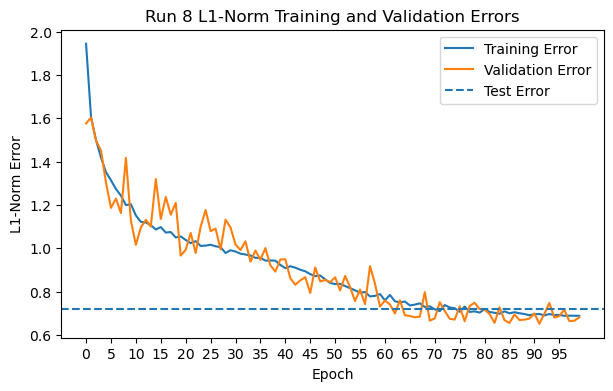


Epoch 1:
Training loss: 6.584, Training prediction error: 2.046
Validation loss: 6.093, Validation prediction error: 1.932

Epoch 2:
Training loss: 6.129, Training prediction error: 1.863
Validation loss: 6.768, Validation prediction error: 1.956

Epoch 3:
Training loss: 5.800, Training prediction error: 1.702
Validation loss: 6.189, Validation prediction error: 1.738

Epoch 4:
Training loss: 5.360, Training prediction error: 1.569
Validation loss: 4.937, Validation prediction error: 1.520

Epoch 5:
Training loss: 4.948, Training prediction error: 1.458
Validation loss: 5.202, Validation prediction error: 1.458

Epoch 6:
Training loss: 4.846, Training prediction error: 1.409
Validation loss: 3.617, Validation prediction error: 1.202

Epoch 7:
Training loss: 4.515, Training prediction error: 1.334
Validation loss: 3.955, Validation prediction error: 1.251

Epoch 8:
Training loss: 4.362, Training prediction error: 1.298
Validation loss: 5.616, Validation prediction error: 1.500

Epoch 9

Training loss: 2.897, Training prediction error: 0.860
Validation loss: 3.114, Validation prediction error: 0.893

Epoch 68:
Training loss: 2.905, Training prediction error: 0.861
Validation loss: 2.386, Validation prediction error: 0.785

Epoch 69:
Training loss: 2.840, Training prediction error: 0.847
Validation loss: 3.126, Validation prediction error: 0.899

Epoch 70:
Training loss: 2.867, Training prediction error: 0.851
Validation loss: 3.111, Validation prediction error: 0.887

Epoch 71:
Training loss: 2.807, Training prediction error: 0.836
Validation loss: 2.634, Validation prediction error: 0.808

Epoch 72:
Training loss: 2.750, Training prediction error: 0.826
Validation loss: 3.005, Validation prediction error: 0.871

Epoch 73:
Training loss: 2.721, Training prediction error: 0.817
Validation loss: 2.994, Validation prediction error: 0.861

Epoch 74:
Training loss: 2.712, Training prediction error: 0.816
Validation loss: 2.649, Validation prediction error: 0.807

Epoch 75:


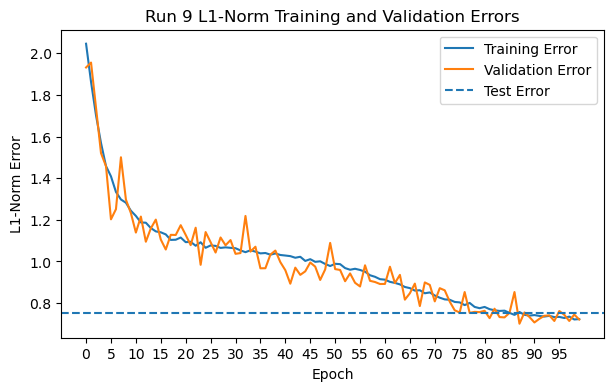


Epoch 1:
Training loss: 5.187, Training prediction error: 1.673
Validation loss: 5.649, Validation prediction error: 1.722

Epoch 2:
Training loss: 4.410, Training prediction error: 1.434
Validation loss: 4.287, Validation prediction error: 1.372

Epoch 3:
Training loss: 4.164, Training prediction error: 1.343
Validation loss: 4.681, Validation prediction error: 1.422

Epoch 4:
Training loss: 4.114, Training prediction error: 1.287
Validation loss: 3.231, Validation prediction error: 1.135

Epoch 5:
Training loss: 3.877, Training prediction error: 1.222
Validation loss: 3.584, Validation prediction error: 1.150

Epoch 6:
Training loss: 3.887, Training prediction error: 1.207
Validation loss: 2.811, Validation prediction error: 1.032

Epoch 7:
Training loss: 3.744, Training prediction error: 1.176
Validation loss: 3.210, Validation prediction error: 1.063

Epoch 8:
Training loss: 3.682, Training prediction error: 1.149
Validation loss: 3.753, Validation prediction error: 1.142

Epoch 9

Training loss: 2.340, Training prediction error: 0.733
Validation loss: 1.882, Validation prediction error: 0.669

Epoch 68:
Training loss: 2.366, Training prediction error: 0.738
Validation loss: 2.141, Validation prediction error: 0.723

Epoch 69:
Training loss: 2.291, Training prediction error: 0.722
Validation loss: 2.407, Validation prediction error: 0.736

Epoch 70:
Training loss: 2.305, Training prediction error: 0.724
Validation loss: 2.077, Validation prediction error: 0.694

Epoch 71:
Training loss: 2.294, Training prediction error: 0.721
Validation loss: 1.939, Validation prediction error: 0.659

Epoch 72:
Training loss: 2.261, Training prediction error: 0.710
Validation loss: 2.076, Validation prediction error: 0.678

Epoch 73:
Training loss: 2.280, Training prediction error: 0.716
Validation loss: 2.280, Validation prediction error: 0.712

Epoch 74:
Training loss: 2.237, Training prediction error: 0.705
Validation loss: 2.183, Validation prediction error: 0.690

Epoch 75:


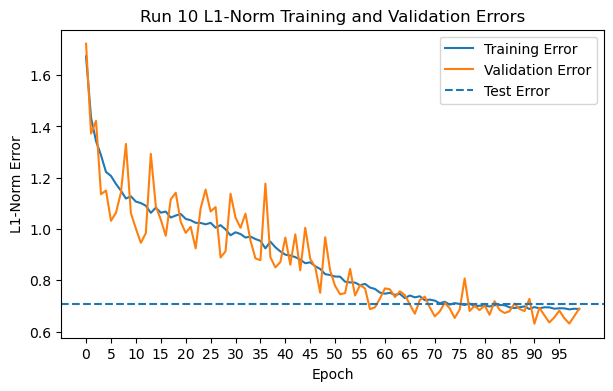

average prediction error:  0.7358849998115317


In [16]:
# Hyperparameter constants
LEARNING_RATE_TRIG = 2.0e-4
NUM_EPOCHS_TRIG = 100
NUM_RUNS_TRIG = 10

if not AUTOGRADING:
    """TASK 1.2: TRAIN MODEL HERE"""
    predictionErrorTrig = onp.zeros((NUM_RUNS_TRIG))
    for run in onp.arange(NUM_RUNS_TRIG):
        model_trig = torch.jit.script(NeuralNetworkTrig().to(DEVICE))
        optimizerTrig = torch.optim.SGD(model_trig.parameters(), lr=LEARNING_RATE_TRIG)
        
        # YOUR CODE HERE
        epochErrorHistoryTrig = runTraining(
            model_trig,
            optimizerTrig,
            NUM_EPOCHS_TRIG,
            train_loader_trig,
            val_loader_trig,
            evaluateRunningModel,
            decoderFunction = trigToTheta
        )
        print(f"\n###############################################################################################")
        print(f"run {run+1} finished!")
        predictionErrorTrig[run] = evaluateRunningModel(model_trig, test_loader_trig, "Test", decoderFunction = trigToTheta)
        print(f"###############################################################################################\n")
        lowEffortPlot(epochErrorHistoryTrig, predictionErrorTrig[run], NUM_EPOCHS_TRIG)
        
    print("average prediction error: ", onp.mean(predictionErrorTrig))
    """TASK 1.2: END"""

Mean prediction error across bins: 0.7089254697494637


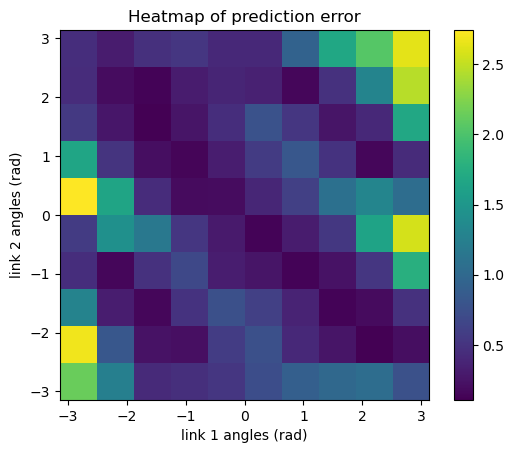

In [17]:
if not AUTOGRADING:
    model_trig_scripted = torch.jit.script(model_trig)
    model_trig_scripted.save(str(statedicts_dir / "task_1-2_model_trig.pt"))
    
    evaluate_model(
        model_trig,
        test_dataset_trig,
        model="trig",
        file="task_1-2_model_trig_prediction_error.pdf",
    )

### 1.2 - Analyse Model performance (4p)
Compare the prediction estimates for $M_{trig}$ with the plot for $M_θ$. Why does indirectly predicting the angle improve the prediction accuracy? **(2p)** (Answer in the cell below)

YOUR ANSWER HERE

"Why does indirectly predicting the angle improve the prediction accuracy?" I don't really see those results, but as outlined in task 1.1,  we no longer see as much of a bias towards the middle (i.e angles close to 0). It should be noted that the learning rate is tuned for the non-trig model, and then we were asked to reuse that hyperparameter for this model as well. It's possible further tuning would have led to better performance, but to me it does not seem likely to make a huge difference in our specific setup. In a more realistic problem however, there might be mislabeled data (not clear to me that there is any such data in this problem), which would have a bigger impact for the theta model as opposed to the trig model, where a small mislabeling cannot cause an unnecessarily large error, which would lead to taking (likely) wrong steps in the optimization.

Why is it not sufficient to predict only sin(θ) and use its inverse θ = arcsin(sin(θ)) to get an estimate of the angle? **(2p)**

YOUR ANSWER HERE

Because $sin(x)$ is not monotonic on the interval $[-\pi, \pi]$. So for instance $sin(\frac{\pi}{3}) = sin( 2\frac{\pi}{3}) \approx 0.866$ is ambiguous.

## Task 1.3: Indirectly predict the angles with a Convolutional Neural Network (10)
Instead of using a vanilla fully-connected neural network, we will build a prediction model $M_{cnn}$ that uses a convolutional neural network (CNN). 

### 1.3 - Prepare the data

Run the functions below to load the data generated in `task_1a_generate_data.ipynb`, split the training into the 70/30 train/validation split, set the batch size to and put them in a dataloader. The data is first put in the class `CNNDataset`. This class again converts the `uint8` pixel values from a range of 0-255 to float values in the range `0-1` while also calculating the values of $\mathrm{sin}(\theta_1), \mathrm{sin}(\theta_2), \mathrm{cos}(\theta_1), \mathrm{cos}(\theta_2)$ to be used as labels instead of just $\theta_1, \theta_2$ as was done in the `ThetaDataset` class. We also permutate the order of the pixel ovbservations from `(number of samples, pixel rows, pixel columns, color channels)` to `(number of samples, color channels, pixel rows, pixel columns, )` as this is the order that the 2d convolution layer expects. The dataloader is again set to shuffle the data randomly before enumerating during the training loop.


In [18]:
if not AUTOGRADING:
    train_loader_cnn, val_loader_cnn = load_training_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_train.npz",
        _rng=init_rng,
        model_type="cnn",
    )
    test_loader_cnn, test_dataset_cnn = load_test_dataset_dataloader(
        datasets_dir / "dataset_double_pendulum_test.npz",
        _rng=init_rng,
        model_type="cnn",
    )

CNN dataset


### 1.3 - Create the model (2p)
Again, create sequential PyTorch model class and define the following architecture with Convolutional and pooling layers. 
- Start with a CNN layer `torch.nn.Conv2d(...)` with 32 filters, kernel size of `3x3` and a ReLU activation function.
- Then add a max pooling layer `torch.nn.MaxPool2d(...)` with a pool size of `2x2`.
- Add another convolutional layer with 10 filters and a ReLU activation function.
- Then add another max pooling layer `torch.nn.MaxPool2d(...)` with a pool size of `2x2`.
- Flatten the output of the pooling layer
- Add a fully connected layer of 30 with a relu activation function.
- Finally, add a fully connected layer without activation. Remember, the number of ouput units must match the dimension of the target data, which is 4 as we will predict the trigonometric function again. 

**note:* No zero padding is needed as the images have enough whitespace at the edges.

In [19]:
"""TASK 1.3: CREATE MODEL HERE"""
INPUT_SHAPE_CONV = next(iter(train_loader_cnn))[0].size()[0::]
print("\nSamples have input shape:", INPUT_SHAPE_CONV)

# YOUR CODE HERE
class NeuralNetworkCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = torch.nn.Conv2d(INPUT_SHAPE_CONV[1], 32, (3,3), stride=1) # input shape: 32x32, no padding -> 30x30 out
        self.maxPool1 = torch.nn.MaxPool2d((2,2), stride=2)                    # 2x2 stride 2 max pooling -> 15x15 out
        self.conv2 = torch.nn.Conv2d(32, 10, (3,3), stride=1)                  # input shape: 15x15, no padding -> 13x13 out
        self.maxPool2 = torch.nn.MaxPool2d((2,2), stride=2)                    # 2x2 stride 2 max pooling -> 6x6 (floors by default)
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.Linear(10*(6*6), 30)
        self.output = torch.nn.Linear(30, 4)
    
    def forward(self, x):
        return self.output(\
            torch.nn.functional.relu(self.dense1(\
            self.flatten(\
            self.maxPool2(\
            torch.nn.functional.relu(self.conv2(\
            self.maxPool1(\
            torch.nn.functional.relu(self.conv1(x)) ))))))))
    
"""TASK 1.3: END HERE"""

model_cnn = torch.jit.script(NeuralNetworkCNN().to(DEVICE))
total_params_cnn = sum(p.numel() for p in model_cnn.parameters())
print("total number of model parameters: ", total_params_cnn)


Samples have input shape: torch.Size([64, 3, 32, 32])
total number of model parameters:  14740


### 1.3 - Train the model (2p)

Train the model with the same training parameters defined below as in task 1.1 and 1.2 but using the training data `train_loader_cnn`. Again, Tune the learning rate in the optimizer to give the best performance on the validation and test set over the 100 epochs. Do this 10 times and record the prediction error of the final model of each of the 10 runs on the test dataset `test_loader_cnn` using the function `evaluate_model_test_data_cnn`. Don't forget to reinitialize the parameters on each run! **Hints:** 
- reduce the number of epochs and lower the number of runs to `1` while getting your model working. 
- The try in the range of 1e-1 to 1e-5 for the learning rate

#### One last thing!
A Convolutional neural network that can predict angles is required for task 2b. Therefore, focus getting the perfect learning and optimal model accuracy with this Neural Network to see how far you can increase the prediction accuracy of link angles. Be warned, the accuracy of your model will affect the performance of you controller in task 2b.


Epoch 1:
Training loss: 4.996, Training prediction error: 1.742
Validation loss: 6.487, Validation prediction error: 1.909

Epoch 2:
Training loss: 5.012, Training prediction error: 1.567
Validation loss: 4.355, Validation prediction error: 1.328

Epoch 3:
Training loss: 3.996, Training prediction error: 1.246
Validation loss: 3.814, Validation prediction error: 1.182

Epoch 4:
Training loss: 3.677, Training prediction error: 1.129
Validation loss: 3.057, Validation prediction error: 0.983

Epoch 5:
Training loss: 2.902, Training prediction error: 0.923
Validation loss: 2.583, Validation prediction error: 0.823

Epoch 6:
Training loss: 2.614, Training prediction error: 0.809
Validation loss: 2.191, Validation prediction error: 0.730

Epoch 7:
Training loss: 2.297, Training prediction error: 0.726
Validation loss: 1.945, Validation prediction error: 0.660

Epoch 8:
Training loss: 2.054, Training prediction error: 0.672
Validation loss: 2.049, Validation prediction error: 0.668

Epoch 9

Training loss: 0.335, Training prediction error: 0.109
Validation loss: 0.362, Validation prediction error: 0.113

Epoch 68:
Training loss: 0.342, Training prediction error: 0.109
Validation loss: 0.342, Validation prediction error: 0.110

Epoch 69:
Training loss: 0.331, Training prediction error: 0.107
Validation loss: 0.361, Validation prediction error: 0.112

Epoch 70:
Training loss: 0.339, Training prediction error: 0.108
Validation loss: 0.348, Validation prediction error: 0.109

Epoch 71:
Training loss: 0.339, Training prediction error: 0.107
Validation loss: 0.354, Validation prediction error: 0.110

Epoch 72:
Training loss: 0.336, Training prediction error: 0.106
Validation loss: 0.338, Validation prediction error: 0.107

Epoch 73:
Training loss: 0.318, Training prediction error: 0.103
Validation loss: 0.349, Validation prediction error: 0.107

Epoch 74:
Training loss: 0.319, Training prediction error: 0.103
Validation loss: 0.351, Validation prediction error: 0.108

Epoch 75:


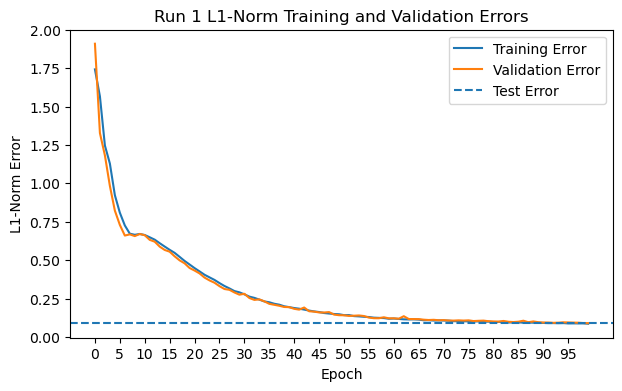


Epoch 1:
Training loss: 6.634, Training prediction error: 1.966
Validation loss: 3.522, Validation prediction error: 1.325

Epoch 2:
Training loss: 3.642, Training prediction error: 1.211
Validation loss: 3.784, Validation prediction error: 1.180

Epoch 3:
Training loss: 3.536, Training prediction error: 1.122
Validation loss: 3.592, Validation prediction error: 1.113

Epoch 4:
Training loss: 3.606, Training prediction error: 1.100
Validation loss: 3.896, Validation prediction error: 1.124

Epoch 5:
Training loss: 3.444, Training prediction error: 1.026
Validation loss: 2.737, Validation prediction error: 0.872

Epoch 6:
Training loss: 2.923, Training prediction error: 0.890
Validation loss: 2.983, Validation prediction error: 0.879

Epoch 7:
Training loss: 2.537, Training prediction error: 0.782
Validation loss: 2.533, Validation prediction error: 0.778

Epoch 8:
Training loss: 2.378, Training prediction error: 0.730
Validation loss: 2.007, Validation prediction error: 0.651

Epoch 9

Training loss: 0.341, Training prediction error: 0.105
Validation loss: 0.306, Validation prediction error: 0.098

Epoch 68:
Training loss: 0.330, Training prediction error: 0.102
Validation loss: 0.358, Validation prediction error: 0.108

Epoch 69:
Training loss: 0.327, Training prediction error: 0.101
Validation loss: 0.320, Validation prediction error: 0.100

Epoch 70:
Training loss: 0.327, Training prediction error: 0.101
Validation loss: 0.323, Validation prediction error: 0.100

Epoch 71:
Training loss: 0.328, Training prediction error: 0.101
Validation loss: 0.302, Validation prediction error: 0.096

Epoch 72:
Training loss: 0.326, Training prediction error: 0.100
Validation loss: 0.323, Validation prediction error: 0.099

Epoch 73:
Training loss: 0.314, Training prediction error: 0.098
Validation loss: 0.323, Validation prediction error: 0.099

Epoch 74:
Training loss: 0.315, Training prediction error: 0.097
Validation loss: 0.296, Validation prediction error: 0.093

Epoch 75:


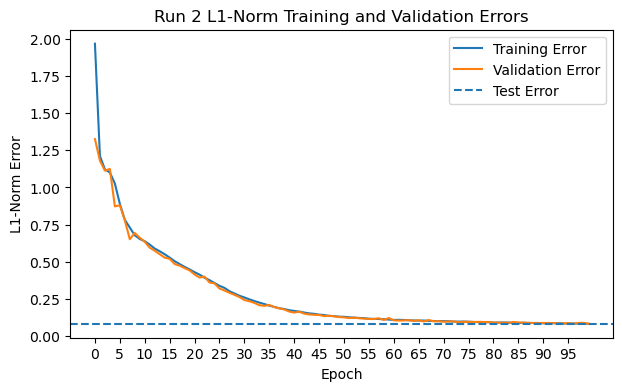


Epoch 1:
Training loss: 5.823, Training prediction error: 1.956
Validation loss: 5.108, Validation prediction error: 1.809

Epoch 2:
Training loss: 4.684, Training prediction error: 1.615
Validation loss: 4.667, Validation prediction error: 1.407

Epoch 3:
Training loss: 4.368, Training prediction error: 1.337
Validation loss: 3.682, Validation prediction error: 1.177

Epoch 4:
Training loss: 3.446, Training prediction error: 1.112
Validation loss: 3.809, Validation prediction error: 1.140

Epoch 5:
Training loss: 3.423, Training prediction error: 1.073
Validation loss: 3.322, Validation prediction error: 1.048

Epoch 6:
Training loss: 3.337, Training prediction error: 1.049
Validation loss: 3.105, Validation prediction error: 1.001

Epoch 7:
Training loss: 3.243, Training prediction error: 1.020
Validation loss: 2.843, Validation prediction error: 0.941

Epoch 8:
Training loss: 3.162, Training prediction error: 0.988
Validation loss: 3.092, Validation prediction error: 0.959

Epoch 9

Training loss: 0.551, Training prediction error: 0.166
Validation loss: 0.628, Validation prediction error: 0.180

Epoch 68:
Training loss: 0.563, Training prediction error: 0.167
Validation loss: 0.589, Validation prediction error: 0.171

Epoch 69:
Training loss: 0.548, Training prediction error: 0.164
Validation loss: 0.555, Validation prediction error: 0.166

Epoch 70:
Training loss: 0.534, Training prediction error: 0.161
Validation loss: 0.565, Validation prediction error: 0.165

Epoch 71:
Training loss: 0.535, Training prediction error: 0.160
Validation loss: 0.540, Validation prediction error: 0.160

Epoch 72:
Training loss: 0.530, Training prediction error: 0.159
Validation loss: 0.563, Validation prediction error: 0.163

Epoch 73:
Training loss: 0.512, Training prediction error: 0.155
Validation loss: 0.490, Validation prediction error: 0.150

Epoch 74:
Training loss: 0.519, Training prediction error: 0.155
Validation loss: 0.534, Validation prediction error: 0.156

Epoch 75:


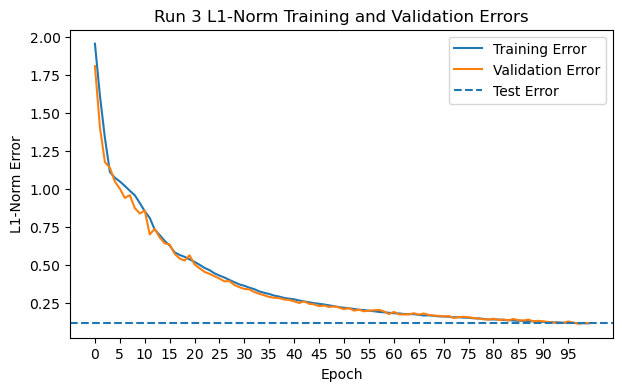


Epoch 1:
Training loss: 7.275, Training prediction error: 2.187
Validation loss: 6.675, Validation prediction error: 1.971

Epoch 2:
Training loss: 6.472, Training prediction error: 1.930
Validation loss: 7.062, Validation prediction error: 2.005

Epoch 3:
Training loss: 5.372, Training prediction error: 1.623
Validation loss: 4.822, Validation prediction error: 1.480

Epoch 4:
Training loss: 4.755, Training prediction error: 1.422
Validation loss: 4.357, Validation prediction error: 1.346

Epoch 5:
Training loss: 4.267, Training prediction error: 1.296
Validation loss: 3.608, Validation prediction error: 1.154

Epoch 6:
Training loss: 3.258, Training prediction error: 1.067
Validation loss: 3.247, Validation prediction error: 1.045

Epoch 7:
Training loss: 3.204, Training prediction error: 1.035
Validation loss: 3.078, Validation prediction error: 1.010

Epoch 8:
Training loss: 3.189, Training prediction error: 1.021
Validation loss: 3.405, Validation prediction error: 1.044

Epoch 9

Training loss: 0.432, Training prediction error: 0.135
Validation loss: 0.436, Validation prediction error: 0.136

Epoch 68:
Training loss: 0.433, Training prediction error: 0.134
Validation loss: 0.402, Validation prediction error: 0.129

Epoch 69:
Training loss: 0.432, Training prediction error: 0.132
Validation loss: 0.390, Validation prediction error: 0.124

Epoch 70:
Training loss: 0.398, Training prediction error: 0.126
Validation loss: 0.390, Validation prediction error: 0.123

Epoch 71:
Training loss: 0.399, Training prediction error: 0.125
Validation loss: 0.381, Validation prediction error: 0.121

Epoch 72:
Training loss: 0.406, Training prediction error: 0.126
Validation loss: 0.391, Validation prediction error: 0.122

Epoch 73:
Training loss: 0.403, Training prediction error: 0.124
Validation loss: 0.365, Validation prediction error: 0.118

Epoch 74:
Training loss: 0.381, Training prediction error: 0.120
Validation loss: 0.371, Validation prediction error: 0.118

Epoch 75:


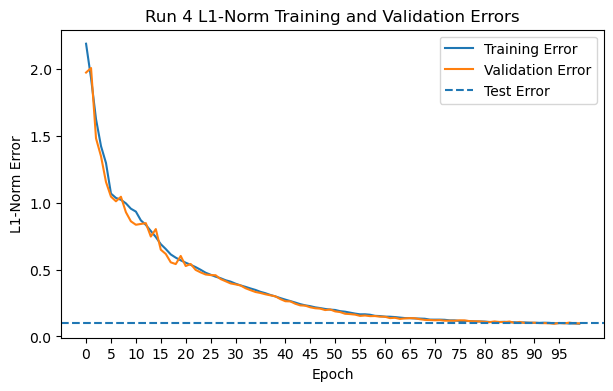


Epoch 1:
Training loss: 4.650, Training prediction error: 1.668
Validation loss: 5.039, Validation prediction error: 1.547

Epoch 2:
Training loss: 4.118, Training prediction error: 1.344
Validation loss: 3.607, Validation prediction error: 1.168

Epoch 3:
Training loss: 3.514, Training prediction error: 1.141
Validation loss: 3.878, Validation prediction error: 1.189

Epoch 4:
Training loss: 3.579, Training prediction error: 1.124
Validation loss: 3.467, Validation prediction error: 1.094

Epoch 5:
Training loss: 3.562, Training prediction error: 1.099
Validation loss: 3.646, Validation prediction error: 1.103

Epoch 6:
Training loss: 3.427, Training prediction error: 1.044
Validation loss: 3.634, Validation prediction error: 1.045

Epoch 7:
Training loss: 3.106, Training prediction error: 0.952
Validation loss: 3.769, Validation prediction error: 1.057

Epoch 8:
Training loss: 2.824, Training prediction error: 0.862
Validation loss: 2.448, Validation prediction error: 0.773

Epoch 9

Training loss: 0.425, Training prediction error: 0.130
Validation loss: 0.424, Validation prediction error: 0.128

Epoch 68:
Training loss: 0.425, Training prediction error: 0.129
Validation loss: 0.406, Validation prediction error: 0.125

Epoch 69:
Training loss: 0.416, Training prediction error: 0.127
Validation loss: 0.409, Validation prediction error: 0.125

Epoch 70:
Training loss: 0.412, Training prediction error: 0.125
Validation loss: 0.460, Validation prediction error: 0.137

Epoch 71:
Training loss: 0.400, Training prediction error: 0.123
Validation loss: 0.409, Validation prediction error: 0.125

Epoch 72:
Training loss: 0.397, Training prediction error: 0.121
Validation loss: 0.417, Validation prediction error: 0.127

Epoch 73:
Training loss: 0.395, Training prediction error: 0.120
Validation loss: 0.387, Validation prediction error: 0.118

Epoch 74:
Training loss: 0.389, Training prediction error: 0.119
Validation loss: 0.399, Validation prediction error: 0.120

Epoch 75:


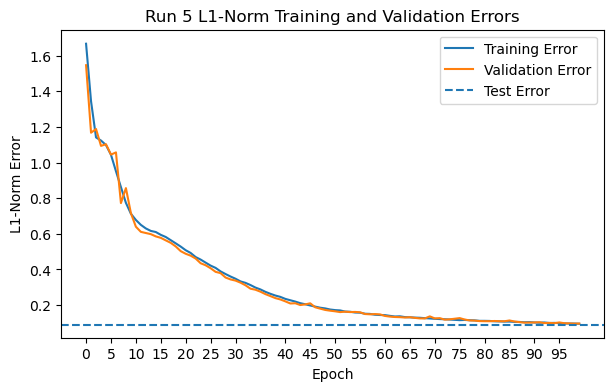


Epoch 1:
Training loss: 10.623, Training prediction error: 2.735
Validation loss: 10.485, Validation prediction error: 2.674

Epoch 2:
Training loss: 7.202, Training prediction error: 2.057
Validation loss: 5.716, Validation prediction error: 1.761

Epoch 3:
Training loss: 5.676, Training prediction error: 1.724
Validation loss: 4.256, Validation prediction error: 1.419

Epoch 4:
Training loss: 4.889, Training prediction error: 1.497
Validation loss: 4.454, Validation prediction error: 1.318

Epoch 5:
Training loss: 4.105, Training prediction error: 1.270
Validation loss: 3.793, Validation prediction error: 1.225

Epoch 6:
Training loss: 3.555, Training prediction error: 1.150
Validation loss: 3.729, Validation prediction error: 1.133

Epoch 7:
Training loss: 3.564, Training prediction error: 1.088
Validation loss: 4.095, Validation prediction error: 1.171

Epoch 8:
Training loss: 3.371, Training prediction error: 1.034
Validation loss: 3.955, Validation prediction error: 1.136

Epoch

Training loss: 0.429, Training prediction error: 0.134
Validation loss: 0.460, Validation prediction error: 0.139

Epoch 68:
Training loss: 0.414, Training prediction error: 0.131
Validation loss: 0.430, Validation prediction error: 0.133

Epoch 69:
Training loss: 0.404, Training prediction error: 0.128
Validation loss: 0.447, Validation prediction error: 0.139

Epoch 70:
Training loss: 0.405, Training prediction error: 0.127
Validation loss: 0.449, Validation prediction error: 0.134

Epoch 71:
Training loss: 0.414, Training prediction error: 0.128
Validation loss: 0.433, Validation prediction error: 0.132

Epoch 72:
Training loss: 0.394, Training prediction error: 0.124
Validation loss: 0.437, Validation prediction error: 0.132

Epoch 73:
Training loss: 0.396, Training prediction error: 0.124
Validation loss: 0.433, Validation prediction error: 0.129

Epoch 74:
Training loss: 0.404, Training prediction error: 0.124
Validation loss: 0.439, Validation prediction error: 0.131

Epoch 75:


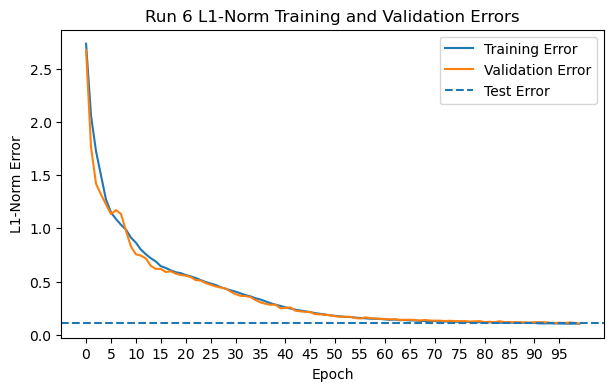


Epoch 1:
Training loss: 7.137, Training prediction error: 2.123
Validation loss: 5.251, Validation prediction error: 1.757

Epoch 2:
Training loss: 5.695, Training prediction error: 1.738
Validation loss: 4.656, Validation prediction error: 1.405

Epoch 3:
Training loss: 5.327, Training prediction error: 1.520
Validation loss: 5.729, Validation prediction error: 1.571

Epoch 4:
Training loss: 4.775, Training prediction error: 1.396
Validation loss: 4.130, Validation prediction error: 1.253

Epoch 5:
Training loss: 3.973, Training prediction error: 1.184
Validation loss: 4.010, Validation prediction error: 1.154

Epoch 6:
Training loss: 3.425, Training prediction error: 1.039
Validation loss: 3.041, Validation prediction error: 0.960

Epoch 7:
Training loss: 3.038, Training prediction error: 0.943
Validation loss: 2.943, Validation prediction error: 0.900

Epoch 8:
Training loss: 2.788, Training prediction error: 0.864
Validation loss: 2.860, Validation prediction error: 0.861

Epoch 9

Training loss: 0.474, Training prediction error: 0.132
Validation loss: 0.494, Validation prediction error: 0.134

Epoch 68:
Training loss: 0.460, Training prediction error: 0.130
Validation loss: 0.480, Validation prediction error: 0.133

Epoch 69:
Training loss: 0.448, Training prediction error: 0.127
Validation loss: 0.443, Validation prediction error: 0.127

Epoch 70:
Training loss: 0.442, Training prediction error: 0.125
Validation loss: 0.497, Validation prediction error: 0.134

Epoch 71:
Training loss: 0.450, Training prediction error: 0.126
Validation loss: 0.460, Validation prediction error: 0.127

Epoch 72:
Training loss: 0.443, Training prediction error: 0.125
Validation loss: 0.491, Validation prediction error: 0.133

Epoch 73:
Training loss: 0.432, Training prediction error: 0.122
Validation loss: 0.406, Validation prediction error: 0.117

Epoch 74:
Training loss: 0.411, Training prediction error: 0.118
Validation loss: 0.461, Validation prediction error: 0.126

Epoch 75:


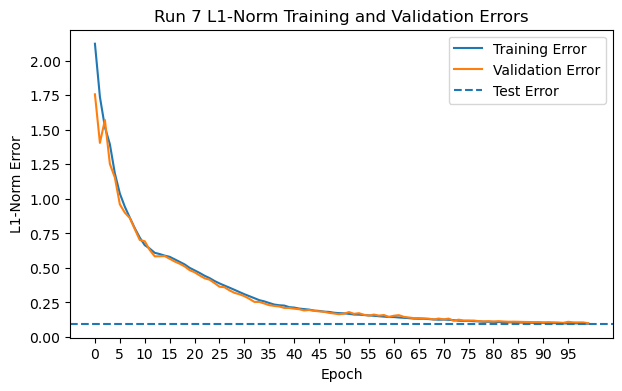


Epoch 1:
Training loss: 6.418, Training prediction error: 1.869
Validation loss: 3.299, Validation prediction error: 1.200

Epoch 2:
Training loss: 3.729, Training prediction error: 1.234
Validation loss: 3.346, Validation prediction error: 1.129

Epoch 3:
Training loss: 3.034, Training prediction error: 1.068
Validation loss: 3.098, Validation prediction error: 1.055

Epoch 4:
Training loss: 3.531, Training prediction error: 1.092
Validation loss: 3.922, Validation prediction error: 1.135

Epoch 5:
Training loss: 3.280, Training prediction error: 1.013
Validation loss: 2.878, Validation prediction error: 0.916

Epoch 6:
Training loss: 2.989, Training prediction error: 0.930
Validation loss: 2.658, Validation prediction error: 0.843

Epoch 7:
Training loss: 2.739, Training prediction error: 0.856
Validation loss: 3.833, Validation prediction error: 1.065

Epoch 8:
Training loss: 2.674, Training prediction error: 0.817
Validation loss: 2.554, Validation prediction error: 0.771

Epoch 9

Training loss: 0.498, Training prediction error: 0.144
Validation loss: 0.501, Validation prediction error: 0.145

Epoch 68:
Training loss: 0.475, Training prediction error: 0.140
Validation loss: 0.503, Validation prediction error: 0.143

Epoch 69:
Training loss: 0.483, Training prediction error: 0.140
Validation loss: 0.496, Validation prediction error: 0.144

Epoch 70:
Training loss: 0.481, Training prediction error: 0.139
Validation loss: 0.487, Validation prediction error: 0.141

Epoch 71:
Training loss: 0.472, Training prediction error: 0.137
Validation loss: 0.485, Validation prediction error: 0.138

Epoch 72:
Training loss: 0.458, Training prediction error: 0.134
Validation loss: 0.503, Validation prediction error: 0.140

Epoch 73:
Training loss: 0.462, Training prediction error: 0.134
Validation loss: 0.494, Validation prediction error: 0.141

Epoch 74:
Training loss: 0.455, Training prediction error: 0.132
Validation loss: 0.480, Validation prediction error: 0.136

Epoch 75:


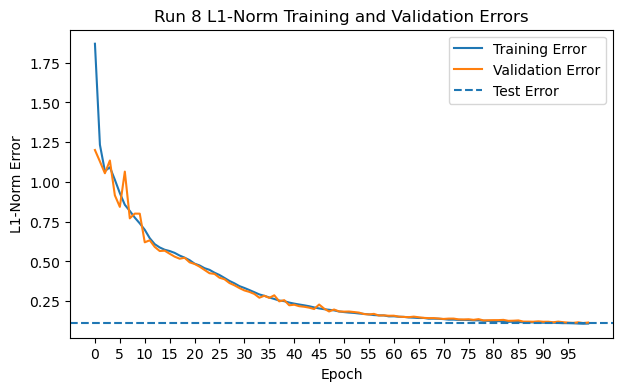


Epoch 1:
Training loss: 8.007, Training prediction error: 2.291
Validation loss: 5.721, Validation prediction error: 1.869

Epoch 2:
Training loss: 5.849, Training prediction error: 1.749
Validation loss: 4.535, Validation prediction error: 1.452

Epoch 3:
Training loss: 4.577, Training prediction error: 1.423
Validation loss: 5.375, Validation prediction error: 1.519

Epoch 4:
Training loss: 4.708, Training prediction error: 1.388
Validation loss: 4.030, Validation prediction error: 1.260

Epoch 5:
Training loss: 3.948, Training prediction error: 1.217
Validation loss: 3.655, Validation prediction error: 1.143

Epoch 6:
Training loss: 3.382, Training prediction error: 1.072
Validation loss: 2.855, Validation prediction error: 0.960

Epoch 7:
Training loss: 2.758, Training prediction error: 0.924
Validation loss: 2.337, Validation prediction error: 0.842

Epoch 8:
Training loss: 2.539, Training prediction error: 0.837
Validation loss: 2.238, Validation prediction error: 0.765

Epoch 9

Training loss: 0.407, Training prediction error: 0.132
Validation loss: 0.435, Validation prediction error: 0.134

Epoch 68:
Training loss: 0.405, Training prediction error: 0.131
Validation loss: 0.449, Validation prediction error: 0.136

Epoch 69:
Training loss: 0.408, Training prediction error: 0.130
Validation loss: 0.440, Validation prediction error: 0.134

Epoch 70:
Training loss: 0.398, Training prediction error: 0.128
Validation loss: 0.401, Validation prediction error: 0.128

Epoch 71:
Training loss: 0.398, Training prediction error: 0.127
Validation loss: 0.413, Validation prediction error: 0.128

Epoch 72:
Training loss: 0.387, Training prediction error: 0.124
Validation loss: 0.415, Validation prediction error: 0.129

Epoch 73:
Training loss: 0.383, Training prediction error: 0.123
Validation loss: 0.408, Validation prediction error: 0.127

Epoch 74:
Training loss: 0.389, Training prediction error: 0.124
Validation loss: 0.391, Validation prediction error: 0.125

Epoch 75:


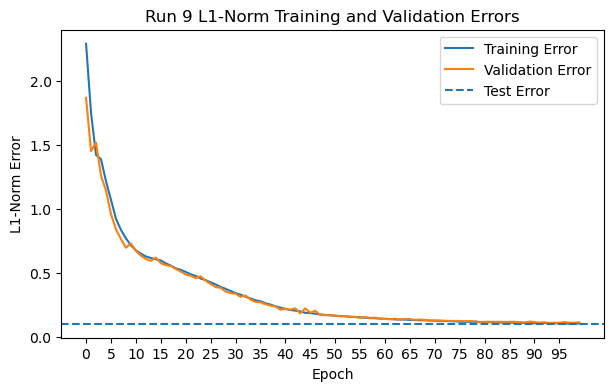


Epoch 1:
Training loss: 6.103, Training prediction error: 1.926
Validation loss: 3.955, Validation prediction error: 1.455

Epoch 2:
Training loss: 4.373, Training prediction error: 1.430
Validation loss: 4.749, Validation prediction error: 1.399

Epoch 3:
Training loss: 4.217, Training prediction error: 1.278
Validation loss: 4.072, Validation prediction error: 1.223

Epoch 4:
Training loss: 3.625, Training prediction error: 1.135
Validation loss: 3.214, Validation prediction error: 1.055

Epoch 5:
Training loss: 3.225, Training prediction error: 1.025
Validation loss: 3.408, Validation prediction error: 1.025

Epoch 6:
Training loss: 3.109, Training prediction error: 0.965
Validation loss: 2.704, Validation prediction error: 0.879

Epoch 7:
Training loss: 2.756, Training prediction error: 0.874
Validation loss: 2.910, Validation prediction error: 0.886

Epoch 8:
Training loss: 2.468, Training prediction error: 0.789
Validation loss: 2.365, Validation prediction error: 0.777

Epoch 9

Training loss: 0.349, Training prediction error: 0.107
Validation loss: 0.376, Validation prediction error: 0.111

Epoch 68:
Training loss: 0.358, Training prediction error: 0.108
Validation loss: 0.391, Validation prediction error: 0.114

Epoch 69:
Training loss: 0.343, Training prediction error: 0.105
Validation loss: 0.385, Validation prediction error: 0.113

Epoch 70:
Training loss: 0.322, Training prediction error: 0.102
Validation loss: 0.344, Validation prediction error: 0.106

Epoch 71:
Training loss: 0.338, Training prediction error: 0.104
Validation loss: 0.358, Validation prediction error: 0.107

Epoch 72:
Training loss: 0.329, Training prediction error: 0.102
Validation loss: 0.380, Validation prediction error: 0.110

Epoch 73:
Training loss: 0.338, Training prediction error: 0.103
Validation loss: 0.365, Validation prediction error: 0.106

Epoch 74:
Training loss: 0.323, Training prediction error: 0.100
Validation loss: 0.374, Validation prediction error: 0.107

Epoch 75:


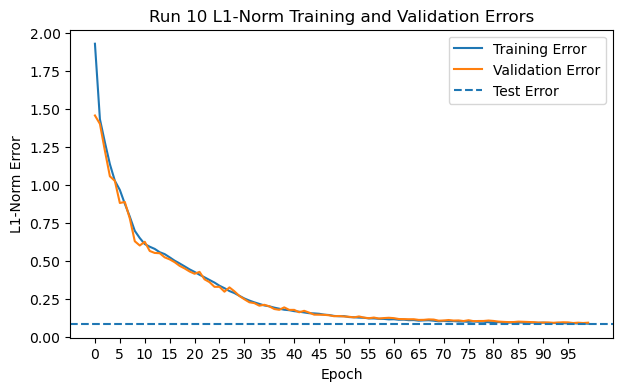

average prediction error:  0.09857261015995014
Finished Training


In [20]:
# Hyperparameter constants
LEARNING_RATE_CONV = 7.0e-3 # 7.0e-3 gave 0.087
NUM_EPOCHS_CONV = 100
NUM_RUNS_CONV = 10

if not AUTOGRADING:
    """TASK 1.3: TRAIN MODEL HERE"""
    predictionErrorCnn = onp.zeros((NUM_RUNS_CONV))

    for run in onp.arange(NUM_RUNS_CONV):
        model_cnn = torch.jit.script(NeuralNetworkCNN().to(DEVICE))
        optimizerCNN = torch.optim.SGD(model_cnn.parameters(), lr=LEARNING_RATE_CONV)
        # YOUR CODE HERE
        epochErrorHistoryCNN = runTraining(
            model_cnn,
            optimizerCNN,
            NUM_EPOCHS_CONV,
            train_loader_cnn,
            val_loader_cnn,
            evaluateRunningModel,
            decoderFunction = trigToTheta
        )
        print(f"\n###############################################################################################")
        print(f"run {run+1} finished!")
        predictionErrorCnn[run] = evaluateRunningModel(model_cnn, test_loader_cnn, "Test", decoderFunction = trigToTheta)
        print(f"###############################################################################################\n")
        lowEffortPlot(epochErrorHistoryCNN, predictionErrorCnn[run], NUM_EPOCHS_CONV)
        
    print("average prediction error: ", onp.mean(predictionErrorCnn))  
    print("Finished Training")
    
    """TASK 1.3: END"""

In [21]:
torch.cuda.empty_cache()

Mean prediction error across bins: 0.09048633365329904


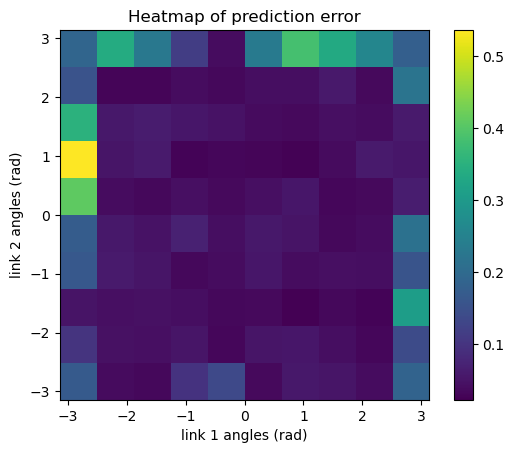

In [22]:
if not AUTOGRADING:
    model_cnn_scripted = torch.jit.script(model_cnn)
    model_cnn_scripted.save(str(statedicts_dir / "task_1-3_model_cnn.pt"))
    
    evaluate_model(
        model_cnn,
        test_dataset_cnn,
        model="cnn",
        file="task_1-3_model_cnn_prediction_error.pdf",
    )

### 1.3 - Analyse and Compare Model performance 
Make a comparison of the different models (i.e. M θ, M trig, M cnn) based on the average prediction accuracy
on the test dataset and the number of trainable parameters. Which model would you prefer and why? (answer in the cell below)

YOUR ANSWER HERE

$M_\theta$ and $M_{trig}$ perform pretty similarly in my case, but of the two the reasons outlined in the previous questions point towards $M_{trig}$ being a more optimal choice. One thing that I didn't mention was that $M_{trig}$ had fewer problem samples which raised the total error, and for that reason it would be easier to examine those samples and try to modify the preprocessing, the training set itself or handle in some other way the problem cases when the model is deployed.

Clearly though, $M_{cnn}$ significantly outperforms both, as expected, and this is without even iterating on the architecture, which was just given to us. None of the models saw any large degree of overfitting, which can be attributed to a relatively low number of parameters as far as neural networks go, as well as the train, validate and test sets being quite easy to learn in general (not much noise or corruption). I would choose $M_{cnn}$, because there really is no competition here.

If you change the activation of the last fully connected layer to ReLU, the prediction accuracy completely deteriorates. Why?

YOUR ANSWER HERE

The ReLU function is $f(x) = max(0, x)$. Our predictions are the values of the trigonometric functions $sin(x)$ and $cos(x)$, which both have ranges of $[-1, -1]$. You would essentially be cutting of the left half-plane of possible angles to predict, making us wrong >= 50% of the time for a uniform test set.

## Task 1.4: Variance across runs (2.5p) 
In the previous tasks, the prediction accuracy varied across different runs even though the underlying code and dataset remained unchanged.

Use the code cell below to set the seed for PyTorch. Train the model for a seed of 0 and then for seed of 1, recording the average prediction accuracy and standard deviation for both.  

In [23]:
torch.manual_seed(0)  # set seed to either 0 or 1

Copy the architecture of $M_{\theta}$ to create a new model below. Don't forget to comment on the code to set the seed again when working on the other tasks.

In [24]:
pred_error_sds = {}
seed = 0

In [25]:
""" TASK 1.4: CREATE MODEL HERE """



class NeuralNetworkThetaSeed(nn.Module):
    def __init__(self):
        super().__init__()
        # YOUR CODE HERE
#         raise NotImplementedError()
"""TASK1.4: END"""
model_theta_seed = model_theta

Set up a training loop as done for the task 1.3 and run this 10 times while having the seed value as 0 and then run it again for a seed of 1. Use the same datasets as in task 1.3. **(0.5p)**. 

In [26]:
if not AUTOGRADING:
    train_loader_theta, val_loader_theta = load_training_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_train.npz"),
        _rng=init_rng,
        model_type="theta",
    )
    test_loader_theta, _ = load_test_dataset_dataloader(
        str(datasets_dir / "dataset_double_pendulum_test.npz"),
        _rng=init_rng,
        model_type="theta",
    )

# Training parameters
optimizer = torch.optim.SGD(model_theta_seed.parameters(), lr=1e-3)
# We choose the mean square loss as it is a regression problem
loss_fn = torch.nn.MSELoss()
num_epochs = 30

# define the path to save the model to
model_theta_seed_path = str(statedicts_dir / f"task_1-4_model_theta_seed-{seed}.pt")

num_runs = 10
pred_error_sds[seed] = onp.zeros((num_runs,))

Theta Dataset


In [27]:
if not AUTOGRADING:
    """ TASK 1.4: TRAIN MODEL HERE """
#     for run in onp.arange(num_runs):
#         model_theta_seed = NeuralNetworkThetaSeed().to(DEVICE)
#         optimizer = torch.optim.SGD(model_theta_seed.parameters(), lr=1e-3)
#         # YOUR CODE HERE
# #         raise NotImplementedError()
    """TASK 1.4: END"""

Mean prediction error across bins: 0.09048633365329904


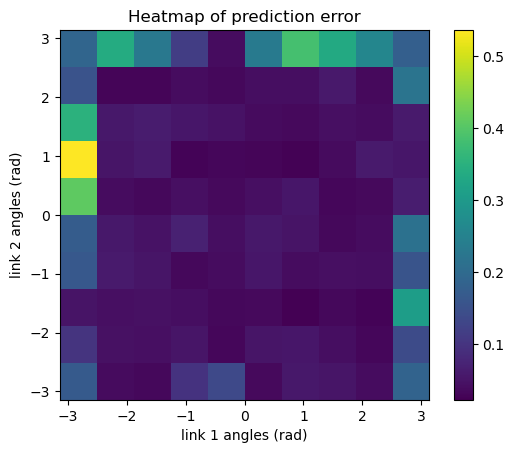

In [28]:
if not AUTOGRADING:
    model_cnn_scripted = torch.jit.script(model_theta_seed)
    #Save your models
    model_cnn_scripted.save(str(statedicts_dir / "task_1-4_model_theta_seed0.pt"))
    model_cnn_scripted.save(str(statedicts_dir / "task_1-4_model_theta_seed1.pt"))

    
    evaluate_model(
        model_cnn,
        test_dataset_cnn,
        model="cnn",
        file="task_1-4_model_cnn_prediction_error.pdf",
    )

- What do you observe? (1p)

- What is the benefit of seeding the pseudo-random generator in practice? **(1p)**

Write your answers in the cell below

YOUR ANSWER HERE

This question is easy:

    "As we expect that a large share of you have already completed / worked on task 1.4, we do not want to ask you to re-do this subtask. Therefore, everyone will automatically be granted the full 2.5 points for task 1.4." 
    (from Brightspace, posted on 14 March, 2023 22:34)

but yes, pseudo-random generators are deterministic, and gradient based optimization with random weight initialization will have different results each time, so seeding the random generator allows for reproducibility. The type of weight initialization that pytorch uses by default depends on the type of layer. 

## Task 1.5: Spiking neural networks (15p)

If our goal is to control the double pendulum, the angular velocity $\dot{\theta}$ is generally also required. However, temporal information cannot be extracted from individual images. We are going to utilize the temporal advantage of the spiking neural networks (SNN) to predict the angular velocity of each link. Instead of static individual images, we adopt event-based data as the input.

### 1.5 - Warm Up
Use the Jupyter notebook `task_1-5_SNN_warmup.ipynb` to understand the neuron structure of SNNs, construct a LIF neuron model and a simple fully connected SNN.

### 1.5 - Prepare the dataset

In this part, the dataloader has been defined, and the two data sets `train_loader_snn` and `test_loader_snn` have been generated, which can be directly used to train the network. The two datasets are the same size. The batch_size has chosen 16. And we shuffle the dataset by setting shuffle to true. At the same time, to make the size of the data set just divisible by batch_size, we set drop_last to true to discard the last set of data that is less than one batch. At the same time, we did not set the validation set.

Therefore, the size of each piece of data in dataloader is: （batch_size: 16, time_step: 20, channels: 2, size: 32, size: 32）.

In [29]:
# This part has to be same as task_1a_generate_data.ipynb
train_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
train_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)
test_th1_range = jnp.arange(-jnp.pi / 6.0, jnp.pi / 6.0, jnp.pi / 30.0)
test_th2_range = jnp.arange(-jnp.pi, jnp.pi, jnp.pi / 6.0)

TRAIN_NUM_DATA = len(train_th1_range) * len(train_th2_range)
TEST_NUM_DATA = len(test_th1_range) * len(test_th2_range)
NUM_SNN_DATA = 5

In [30]:
if not AUTOGRADING:
    train_set_snn = SNNDataset(
        datasets_dir / "event_based_data" / "train",
        TRAIN_NUM_DATA,
        NUM_SNN_DATA,
    )
    train_loader_snn = DataLoader(train_set_snn, batch_size=16, shuffle=True, drop_last=True)

    test_set_snn = SNNDataset(
        datasets_dir / "event_based_data" / "test",
        TEST_NUM_DATA,
        NUM_SNN_DATA,
    )
    test_loader_snn = DataLoader(test_set_snn, batch_size=16, shuffle=True, drop_last=True)

### 1.5 - Create the model (4p)

We create a class called `snnModel` extending `nn.Module`. Please fill this class to implement the model of SNNs. We adopt the LIF model for neurons.

The structure of the network is like:

* Start with a convolutional layer with 16 as the number of output channels, kernel size of `5x5`.
* Then, add a max pooling layer with a pooling size of `4x4`.
* Add the second convolutional layer with 16 as output channel size, kernel size of `3x3`.
* Add the third convolutional layer with 16 as output channel size, kernel size of `3x3`.
* All neurons use LIF model, and obtain the membrane potential in a recurrent way.
* Flatten the membrane potential in the last layer and feed it into two fully connected layers with the ReLU activation fuction in between. We recommend the input size of the second fully connected layer is 640. The final output number must match the dimension of our target data which is 2.

Meanwhile, for LIF model, we use `fast_sigmoid` function as the surrogate function, and the decay rate `beta` is 0.8. It is worth noting that we need to use the recurrent method to process event-based data. So,

* We should use the for-loop to traverse each time step of the input event-based data. For the data of each time step, we can use the convolution operation to process the data as usual. Each convolution operation is followed by a layer of SNN neurons. Finally, the membrane potential of the last layer of all time steps is used as output. Therefore, the expected output format of the SNN part should be `[batch_size: 16, time_step: 20, conv_channel: (should be the channel size of the last convolutional layer), size: (output size), size: (output size)]`.
* The first dimension of the input data is batch size, but not the time steps. So we need to transpose the input tensor first and then use for-loop to process it.
* The final non-linear layer (two fully connected layers with ReLU) should be the conventional neurons instead of SNN neurons.
* Do not forget to initialize the LIF neurons!

In [31]:
# YOUR CODE HERE
class snnModel(nn.Module):
    def __init__(
        self, inputSize=(32, 32), beta=0.8, timeSteps=20, spikingGradient=surrogate.fast_sigmoid(slope=25)
    ):
        super().__init__()
        self.timeSteps = timeSteps
        # Block 1
        self.convolution1 = nn.Conv2d(2, 16, (5,5), stride=1)                         # 32x32 input, (5,5) kernel no padding -> 28x28
        self.leakyIntegrateAndFire1 = snn.Leaky(beta=beta, spike_grad=spikingGradient)
        self.maxPooling1 = nn.MaxPool2d((4,4), stride=1)                              # 28x28 input 4x4 stride 1 max pool -> 25x25
        # Block 2
        self.convolution2 = nn.Conv2d(16, 16, (3,3))                                  # 25x25 input, (3,3) kernel no padding -> 23x23                  
        self.leakyIntegrateAndFire2 = snn.Leaky(beta=beta, spike_grad=spikingGradient)
        # Block 3
        self.convolution3 = nn.Conv2d(16, 16, (3,3))                                  # 23x23 input, (3,3) kernel no padding -> 21x21
        self.leakyIntegrateAndFire3 = snn.Leaky(beta=beta, spike_grad=spikingGradient)
        # Head
        self.flatten = nn.Flatten(1, -1)
        self.dense1 = nn.Linear(20*16*21*21, 640)
        self.output = nn.Linear(640, 2) 
        
    def forward(self, x):
        membrane3History = torch.zeros((self.timeSteps, 16, 16, 21, 21)).to(DEVICE)
        x = torch.swapaxes(x, 0, 1)
        # Process event based data with spikey conv layers
        for t in onp.arange(self.timeSteps):
            spike1, membrane1 = self.leakyIntegrateAndFire1(self.convolution1(x[t]), self.leakyIntegrateAndFire1.init_leaky())
            spike2, membrane2 = self.leakyIntegrateAndFire1(self.convolution2(self.maxPooling1(spike1)), self.leakyIntegrateAndFire2.init_leaky())
            spike3, membrane3 = self.leakyIntegrateAndFire1(self.convolution2(spike2), self.leakyIntegrateAndFire3.init_leaky())
            membrane3History[t] = membrane3   
        # Dense layers and return
        membrane3History = torch.swapaxes(membrane3History, 0, 1)
        return self.output(F.relu(self.dense1(self.flatten(membrane3History))))
"""TASK1.5: END"""

model_snn = snnModel().to(DEVICE)
total_params_snn = sum(p.numel() for p in model_snn.parameters())
print("total number of model parameters: ", total_params_snn)

total number of model parameters:  90324178


### 1.5 - Train the model (3p)

Train the SNN model in the same way with other models. We recommend using `1e-3` as the learning rate and training the model for 200 epochs.

In [32]:
optimizer = torch.optim.Adam(model_snn.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()
num_epochs = 200


Epoch 1:
Training loss: 26.279, Training prediction error: 3.923
Validation loss: 24.267, Validation prediction error: 3.764

Epoch 2:
Training loss: 23.953, Training prediction error: 3.799
Validation loss: 23.755, Validation prediction error: 3.772

Epoch 3:
Training loss: 24.103, Training prediction error: 3.794
Validation loss: 24.796, Validation prediction error: 3.789

Epoch 4:
Training loss: 22.371, Training prediction error: 3.341
Validation loss: 14.990, Validation prediction error: 2.710

Epoch 5:
Training loss: 14.659, Training prediction error: 2.646
Validation loss: 12.540, Validation prediction error: 2.458

Epoch 6:
Training loss: 15.427, Training prediction error: 2.735
Validation loss: 11.910, Validation prediction error: 2.388

Epoch 7:
Training loss: 11.347, Training prediction error: 2.283
Validation loss: 9.477, Validation prediction error: 2.149

Epoch 8:
Training loss: 11.445, Training prediction error: 2.338
Validation loss: 16.161, Validation prediction error:

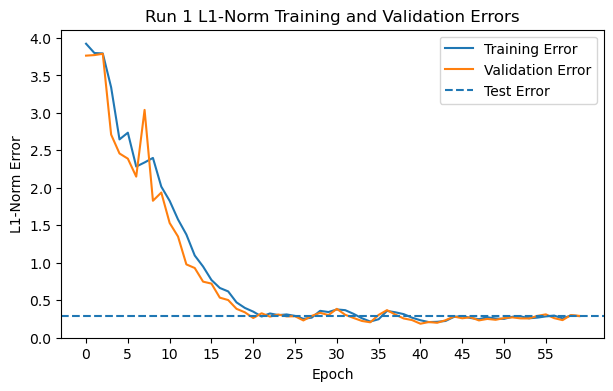


Epoch 1:
Training loss: 29.098, Training prediction error: 4.103
Validation loss: 24.093, Validation prediction error: 3.755

Epoch 2:
Training loss: 24.418, Training prediction error: 3.790
Validation loss: 36.783, Validation prediction error: 4.924

Epoch 3:
Training loss: 25.102, Training prediction error: 3.721
Validation loss: 23.301, Validation prediction error: 3.611

Epoch 4:
Training loss: 18.584, Training prediction error: 2.964
Validation loss: 17.767, Validation prediction error: 2.929

Epoch 5:
Training loss: 15.304, Training prediction error: 2.585
Validation loss: 11.646, Validation prediction error: 2.215

Epoch 6:
Training loss: 11.793, Training prediction error: 2.237
Validation loss: 10.667, Validation prediction error: 2.228

Epoch 7:
Training loss: 9.836, Training prediction error: 2.035
Validation loss: 6.530, Validation prediction error: 1.679

Epoch 8:
Training loss: 6.645, Training prediction error: 1.637
Validation loss: 4.175, Validation prediction error: 1.

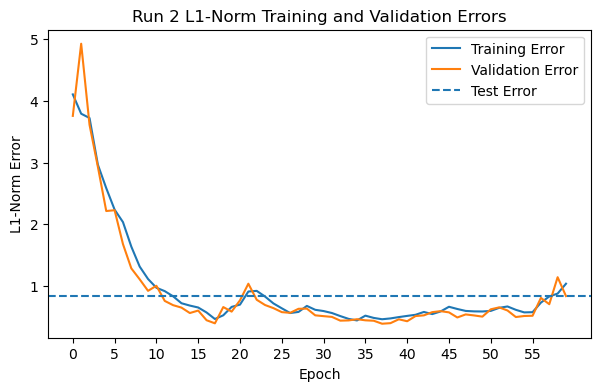


Epoch 1:
Training loss: 27.591, Training prediction error: 4.008
Validation loss: 24.174, Validation prediction error: 3.837

Epoch 2:
Training loss: 24.318, Training prediction error: 3.842
Validation loss: 24.012, Validation prediction error: 3.804

Epoch 3:
Training loss: 24.574, Training prediction error: 3.833
Validation loss: 27.730, Validation prediction error: 4.136

Epoch 4:
Training loss: 21.048, Training prediction error: 3.159
Validation loss: 14.953, Validation prediction error: 2.584

Epoch 5:
Training loss: 15.860, Training prediction error: 2.671
Validation loss: 15.013, Validation prediction error: 2.660

Epoch 6:
Training loss: 15.157, Training prediction error: 2.581
Validation loss: 12.267, Validation prediction error: 2.380

Epoch 7:
Training loss: 11.116, Training prediction error: 2.228
Validation loss: 7.628, Validation prediction error: 1.860

Epoch 8:
Training loss: 8.445, Training prediction error: 1.932
Validation loss: 5.898, Validation prediction error: 1

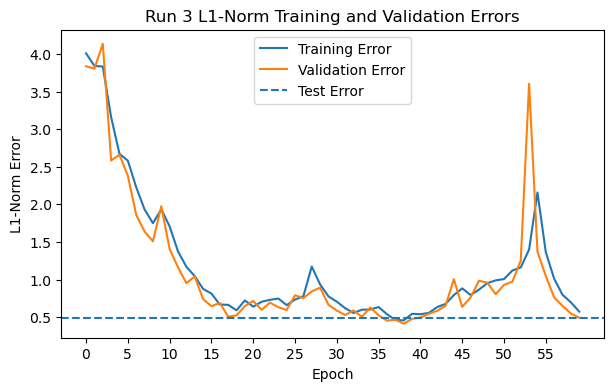


Epoch 1:
Training loss: 33.970, Training prediction error: 4.179
Validation loss: 24.105, Validation prediction error: 3.763

Epoch 2:
Training loss: 23.942, Training prediction error: 3.777
Validation loss: 23.846, Validation prediction error: 3.777

Epoch 3:
Training loss: 23.907, Training prediction error: 3.796
Validation loss: 23.952, Validation prediction error: 3.797

Epoch 4:
Training loss: 24.517, Training prediction error: 3.648
Validation loss: 16.044, Validation prediction error: 2.890

Epoch 5:
Training loss: 16.206, Training prediction error: 2.714
Validation loss: 12.382, Validation prediction error: 2.360

Epoch 6:
Training loss: 14.413, Training prediction error: 2.572
Validation loss: 11.849, Validation prediction error: 2.359

Epoch 7:
Training loss: 11.177, Training prediction error: 2.162
Validation loss: 7.886, Validation prediction error: 1.811

Epoch 8:
Training loss: 7.465, Training prediction error: 1.764
Validation loss: 4.927, Validation prediction error: 1

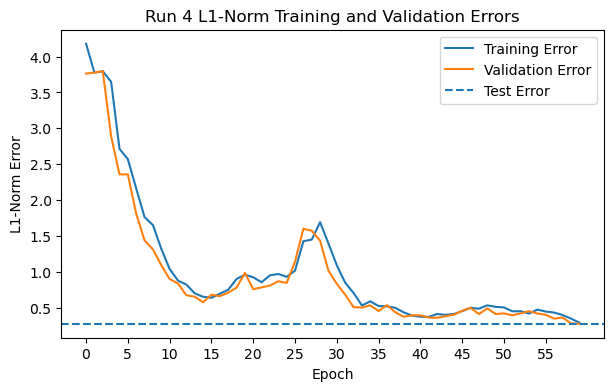


Epoch 1:
Training loss: 30.577, Training prediction error: 4.098
Validation loss: 23.745, Validation prediction error: 3.759

Epoch 2:
Training loss: 24.560, Training prediction error: 3.828
Validation loss: 23.562, Validation prediction error: 3.578

Epoch 3:
Training loss: 20.133, Training prediction error: 3.206
Validation loss: 17.322, Validation prediction error: 2.771

Epoch 4:
Training loss: 14.963, Training prediction error: 2.634
Validation loss: 11.698, Validation prediction error: 2.289

Epoch 5:
Training loss: 11.952, Training prediction error: 2.269
Validation loss: 7.377, Validation prediction error: 1.759

Epoch 6:
Training loss: 7.617, Training prediction error: 1.865
Validation loss: 7.449, Validation prediction error: 1.795

Epoch 7:
Training loss: 5.507, Training prediction error: 1.531
Validation loss: 3.022, Validation prediction error: 1.158

Epoch 8:
Training loss: 3.717, Training prediction error: 1.256
Validation loss: 2.671, Validation prediction error: 1.112

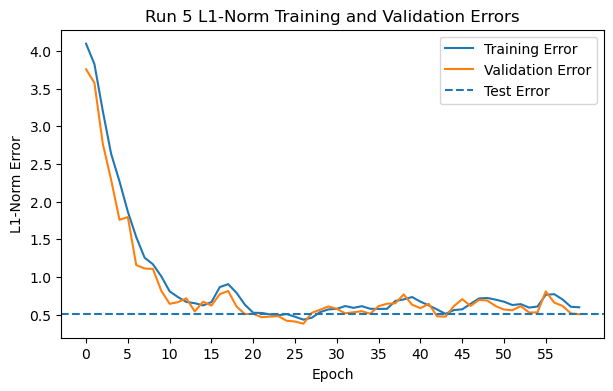


Epoch 1:
Training loss: 31.826, Training prediction error: 4.104
Validation loss: 23.711, Validation prediction error: 3.804

Epoch 2:
Training loss: 23.938, Training prediction error: 3.790
Validation loss: 23.773, Validation prediction error: 3.766

Epoch 3:
Training loss: 24.188, Training prediction error: 3.794
Validation loss: 23.866, Validation prediction error: 3.783

Epoch 4:
Training loss: 24.112, Training prediction error: 3.809
Validation loss: 25.181, Validation prediction error: 3.800

Epoch 5:
Training loss: 22.751, Training prediction error: 3.468
Validation loss: 19.387, Validation prediction error: 3.203

Epoch 6:
Training loss: 17.222, Training prediction error: 2.859
Validation loss: 13.216, Validation prediction error: 2.395

Epoch 7:
Training loss: 12.902, Training prediction error: 2.298
Validation loss: 9.714, Validation prediction error: 1.948

Epoch 8:
Training loss: 10.119, Training prediction error: 2.004
Validation loss: 7.210, Validation prediction error: 

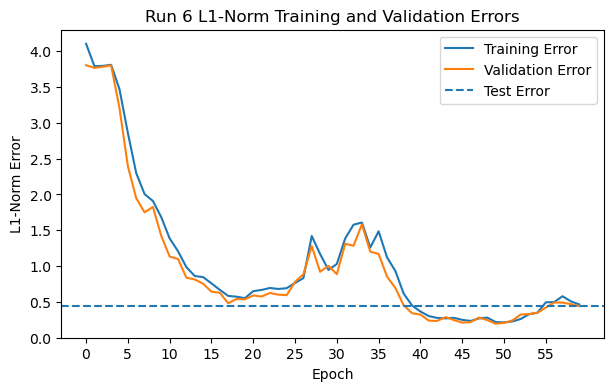


Epoch 1:
Training loss: 32.803, Training prediction error: 4.121
Validation loss: 24.036, Validation prediction error: 3.800

Epoch 2:
Training loss: 24.201, Training prediction error: 3.835
Validation loss: 23.985, Validation prediction error: 3.785

Epoch 3:
Training loss: 23.992, Training prediction error: 3.769
Validation loss: 24.117, Validation prediction error: 3.815

Epoch 4:
Training loss: 24.054, Training prediction error: 3.812
Validation loss: 23.980, Validation prediction error: 3.782

Epoch 5:
Training loss: 28.238, Training prediction error: 3.890
Validation loss: 20.851, Validation prediction error: 3.379

Epoch 6:
Training loss: 27.462, Training prediction error: 3.964
Validation loss: 25.006, Validation prediction error: 3.642

Epoch 7:
Training loss: 19.759, Training prediction error: 3.138
Validation loss: 16.474, Validation prediction error: 2.737

Epoch 8:
Training loss: 16.181, Training prediction error: 2.708
Validation loss: 13.688, Validation prediction error

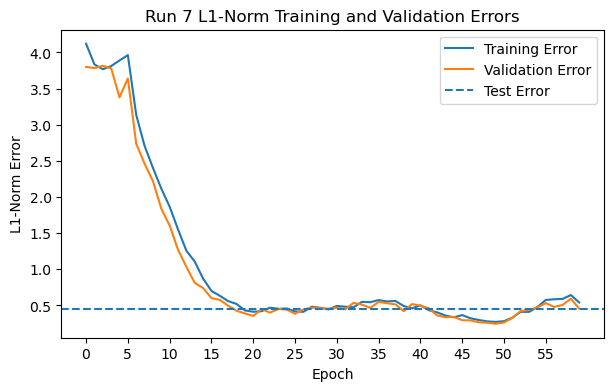


Epoch 1:
Training loss: 28.493, Training prediction error: 4.048
Validation loss: 24.390, Validation prediction error: 3.803

Epoch 2:
Training loss: 24.312, Training prediction error: 3.806
Validation loss: 24.044, Validation prediction error: 3.814

Epoch 3:
Training loss: 24.133, Training prediction error: 3.799
Validation loss: 23.864, Validation prediction error: 3.781

Epoch 4:
Training loss: 25.284, Training prediction error: 3.884
Validation loss: 26.384, Validation prediction error: 3.747

Epoch 5:
Training loss: 26.134, Training prediction error: 3.704
Validation loss: 20.326, Validation prediction error: 3.287

Epoch 6:
Training loss: 18.094, Training prediction error: 2.950
Validation loss: 13.157, Validation prediction error: 2.355

Epoch 7:
Training loss: 12.407, Training prediction error: 2.243
Validation loss: 7.860, Validation prediction error: 1.807

Epoch 8:
Training loss: 7.797, Training prediction error: 1.780
Validation loss: 4.396, Validation prediction error: 1

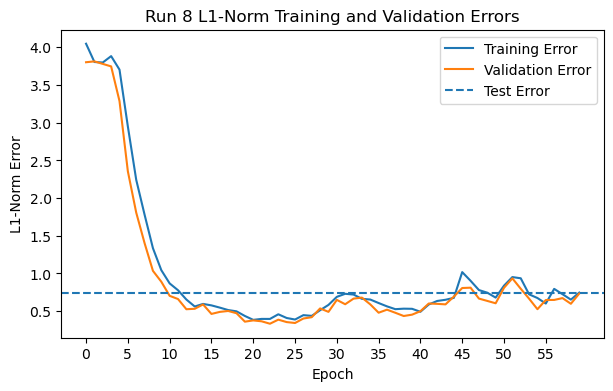


Epoch 1:
Training loss: 27.973, Training prediction error: 4.063
Validation loss: 23.758, Validation prediction error: 3.765

Epoch 2:
Training loss: 24.211, Training prediction error: 3.808
Validation loss: 23.963, Validation prediction error: 3.783

Epoch 3:
Training loss: 24.154, Training prediction error: 3.791
Validation loss: 23.915, Validation prediction error: 3.794

Epoch 4:
Training loss: 24.067, Training prediction error: 3.813
Validation loss: 23.938, Validation prediction error: 3.801

Epoch 5:
Training loss: 24.200, Training prediction error: 3.812
Validation loss: 24.170, Validation prediction error: 3.831

Epoch 6:
Training loss: 39.083, Training prediction error: 4.183
Validation loss: 23.450, Validation prediction error: 3.740

Epoch 7:
Training loss: 25.983, Training prediction error: 3.916
Validation loss: 23.878, Validation prediction error: 3.765

Epoch 8:
Training loss: 24.070, Training prediction error: 3.793
Validation loss: 24.262, Validation prediction error

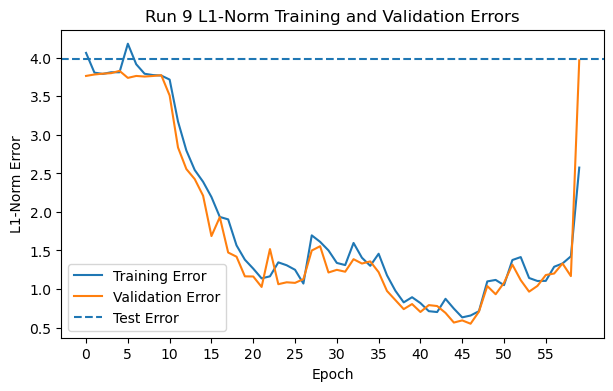


Epoch 1:
Training loss: 28.959, Training prediction error: 4.044
Validation loss: 23.893, Validation prediction error: 3.790

Epoch 2:
Training loss: 24.019, Training prediction error: 3.790
Validation loss: 24.057, Validation prediction error: 3.790

Epoch 3:
Training loss: 23.821, Training prediction error: 3.793
Validation loss: 23.804, Validation prediction error: 3.743

Epoch 4:
Training loss: 26.164, Training prediction error: 3.844
Validation loss: 23.031, Validation prediction error: 3.542

Epoch 5:
Training loss: 19.564, Training prediction error: 3.113
Validation loss: 12.899, Validation prediction error: 2.424

Epoch 6:
Training loss: 13.722, Training prediction error: 2.555
Validation loss: 10.559, Validation prediction error: 2.181

Epoch 7:
Training loss: 9.994, Training prediction error: 2.137
Validation loss: 7.062, Validation prediction error: 1.751

Epoch 8:
Training loss: 6.185, Training prediction error: 1.658
Validation loss: 3.330, Validation prediction error: 1.

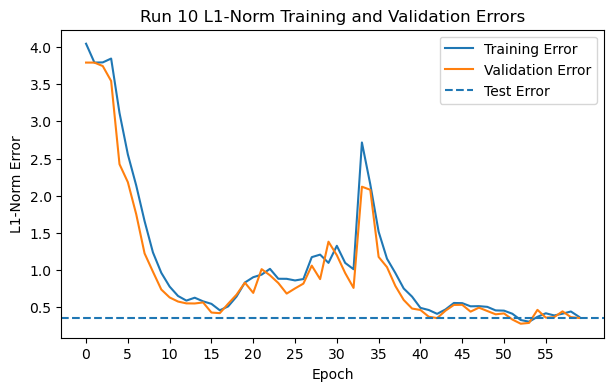

average prediction error:  0.8366764561550036
Finished Training


In [33]:
onp.random.seed(42)
torch.manual_seed(42)
torch.cuda.empty_cache()
# Hyperparameter constants
NUM_RUNS_SNN = 10
NUM_EPOCHS_SNN = 60
LEARNING_RATE_SNN = 1.0e-3

if not AUTOGRADING:
    """TASK 1.5: TRAIN MODEL HERE"""
    # YOUR CODE HERE
    predictionErrorSnn = onp.zeros((NUM_RUNS_SNN))
    for run in onp.arange(NUM_RUNS_SNN):
        model_snn = snnModel().to(DEVICE)
        optimizerSNN = torch.optim.Adam(model_snn.parameters(), lr=LEARNING_RATE_SNN)
        # YOUR CODE HERE
        epochErrorHistorySNN = runTraining(
            model_snn,
            optimizerSNN,
            NUM_EPOCHS_SNN,
            train_loader_snn,
            test_loader_snn, # no validation data loader provided, using test
            evaluateRunningModel,
        )
        print(f"\n###############################################################################################")
        print(f"run {run+1} finished!")
        predictionErrorSnn[run] = evaluateRunningModel(model_snn, test_loader_snn, "Test (Validation at final epoch)")
        print(f"###############################################################################################\n")
        lowEffortPlot(epochErrorHistorySNN, predictionErrorSnn[run], NUM_EPOCHS_SNN)
        
    print("average prediction error: ", onp.mean(predictionErrorSnn))  
    print("Finished Training")
    """TASK 1.5: END"""

In [52]:
# Fix for model being on cuda during cell below
model_snn.to(DEVICE)
from torch.utils.data.dataloader import default_collate
test_loader_snn.collate_fn = lambda x: tuple(x_.to(DEVICE) for x_ in default_collate(x))

In [51]:
# Evaluate the SNN model with test data
if not AUTOGRADING:
    torch.save(model_snn.state_dict(), str(statedicts_dir / "task_1-5_model_snn.pt"))
    
    with torch.no_grad():
        model_snn = model_snn.eval()
        print_loss = 0.0
        count = 0
        for i, (events, targets) in enumerate(test_loader_snn):
            output = model_snn(events)
            loss = loss_fn(output, targets)
            print_loss += loss.item()
            count = count + 1

        print_loss = print_loss / count
        print(f"The MSE loss of the model on the test dataset is: {print_loss}")

The MSE loss of the model on the test dataset is: 0.30981282044101405


### 1.5 - Analysis of results (8p)

Does your loss decrease step by step? During the training process, is the training speed faster or slower comparing to CNN and why? Please analyse the advantages and disadvantages of SNN. **(8p)**

YOUR ANSWER HERE

Yes loss decreases step by step, for a while, until it doesn't anymore. Interestingly it doesn't seem to be because of overfitting in the classical sense, but what I think is happening is that training SNNs using approximations for the gradient (since spike thresholds are not differentiable) via surrogate functions causes the gradient based optimization landscape to become more complex and thus harder to train in. My hypothesis may very well be wrong though.

During training the training speed is slower than the CNN, but the SNN is a **way** bigger model in general, depending on how the task description is interpreted (there is ambiguity as to whether the $4\times4$ max pooling should be of stride $1$ or something else, like $4$). The version of the model I ended up using has $90.324.178$ parameters versus the $14.740$ parameters of the CNN. Not really comparable. Another detail is that the SNN does not have to decode its predictions from trig functions to $\theta$, but the performance hit of this is not enough to make the CNN slower when there is this much of a discrepancy in model size (note that I'm using my own trigToTheta(...) function in this case, but the result would be the same either way since the performance difference in not *that* large).

In short, this experiment, with the architecture given, can **not** be used to judge computational performance (in the software engineering sense), but we can assertain that the SNN has the ability to encode temporal features in direct way (the membrane history is how we accomlish this in our specific model), which the CNN does not (with our specific setup). 

Some light research (googling) into SNNs in general reveals that while each individual spiking neuron obviously has a higher computational cost than that of *normal* artificial neurons, a single one of the former can replace many of the latter. There are also (apparently, though I don't know of them personally) results showing that "any function that can be computed by a small sigmoidal neural net can also be computed by a small network of spiking neurons" ([doi:10.1016/S0893-6080(97)00011-7](https://doi.org/10.1016/S0893-6080(97)00011-7), abstract). SNNs do apparently, at least historically, face problems with regard to computationally efficient training, due to their non-differentiable gradients needing for instance surrogate functions to propagate. On the other hand their conceptual proximity to biological neurons give them a unique ability when it comes to simulating/modeling biological intelligence, which of course has applications in neuroscience. This is not to say that artifical neurons do not also come into play there.

In [53]:
# TODO: read https://www.frontiersin.org/articles/10.3389/fnins.2016.00508/full